# Optimisation de la turbine

Chargement de module utile pour la suite

In [1]:
import pandas as pd                      # pour gerer les tableaux de données comme excel
import numpy as np                       # pour les calculs sur des données matricielles
import matplotlib.pyplot as plt          # pour les traces
import matplotlib.ticker as tck          # pour le formateage de labels
from scipy.interpolate import interp1d,UnivariateSpline   # pour l'interpolation du rendement pondere

In [2]:
# chargement du module specifique
import os
import sys
sys.path.insert(0, os.path.abspath('../common'))
# pour la lecture et l'interpolation de la colline donnée
from module_turbine_data import CollineModeleClass, plot_transient

## Constantes physiques

* L'accélération gravitationnelle `g` en m$^2$/s$^2$ donnée par le client.
* La température de l'eau `theta` en °C donnée par le client.

In [3]:
g = 9.8105
theta = 10 # degree celsius

* Le bief aval de l'ìnstallation est à une élévation d'environ 80m. On peut donc supposer la pression atmosphérique à $p_{atm} = 10^5$ Pa à l'aval. La pression absolue en tenant compte de la chute nette énoncée plus tard sera de l'ordre de 6 à 7 bar. 
* La masse volumique de l'eau `rho` est considérée comme constante dans toute la suite. Elle est estimée à l'aide du tableau B.2 de la norme CEI 60193 pour la temperature de 10°C et la pression absolue attendue (par interpolation linéaire entre 999.7 et 1000.1 kg/m$^3$)

In [4]:
p_atm = 1.0e5
rho = 999.7 + (1000.1-999.7)/(10e5-1e5)*(6e5-1.0e5)
print('rho={0:.1f} kg/m3'.format(rho))

rho=999.9 kg/m3


* La pression de vapeur saturante $p_{va}$ de l'eau est calculée selon la formule 2.5.3.4 de la norme CEI  
\begin{align}
p_{va}\left(\theta\right) = 10^{2.7862+0.0312 \theta -0.000104\theta^2}
\end{align}

In [5]:
p_va = 10**(2.7862+0.0312 *theta -0.000104*theta**2)
print('p_va = {0:.3f} Pa (±7 Pa)'.format(p_va))

p_va = 1224.052 Pa (±7 Pa)


* La viscosité cinématique de l'eau $\nu$ est calculée selon la formule 2.5.3.3 de la norme CEI  
\begin{align}
\nu\left(\theta\right) = e^{-16.921+\frac{396.13}{107.41+\theta}}
\end{align}

In [6]:
nu = np.exp(-16.921+396.13/(107.41+theta))
print('nu = {0:.3e} m2/s2'.format(nu))

nu = 1.308e-06 m2/s2


## Données du problème

* Puissance électrique `P_e` en Watt pour une unité
* Rendement de l'alternateur `eta_alt`
* Rendement hydraulique `eta_h`
* Facteur de puissance `P_ED`
* Chutte nominale `H` en mètre

In [7]:
P_e = 150e6
eta_alt = 98.4/100.
P_ED = 0.9
H = 60.0
Hmax = 63.0
Hmin = 50.0 

* Puissance mécanique $P_m$ (notée `P_m`) correspond à la puissance à l'arbre pour l'énergie hydraulique $P_h=\rho g H Q $ disponible. Les rendements électrique (de l'alternateur) $\eta_{alt}$ et hydraulique $\eta_h$ relient les differentes puissances.
\begin{align}
\eta_{alt} &= \frac{P_e}{P_m}\\
\eta_{h} &= \frac{P_m}{P_h}
\end{align}

In [8]:
P_m = P_e / eta_alt
print('P_m = {0:.2f} MW'.format(P_m/1e6))

P_m = 152.44 MW


## Données du turbinier

Chemin vers le fichier excel contenant les donnees turbinier `input_excel_colline` (mis à jour le 27 Mars 2020). Les données correspondent à des données de performances sur un modèle dont le diamètre a été rapporté à 1 m au nombre de Reynolds de $7\times10^6$. Dans la suite, l'indice M correspondra à des données liées au modèle (par distinction aux données du prototype).

In [9]:
input_excel_colline = os.path.abspath('../common/data_project.xlsx')
Re_M = 7.0e6
# on cree une instance de la classe CollineModele qui sera utilisee pour l'interpolation
colline_modele = CollineModeleClass(input_excel_colline,Re_M,convert_to_m3s=True)

### Fonctions d'interpolation

Création des fonction d'interpolation $Q_{11}=f_{Q}\left(\gamma,n_{11}\right)$ et $\eta_{h,M} = f_{\eta}\left(\gamma,n_{11}\right)$.

Système $Q_{11}$, $N_{11}$ respectivement en $m^3/s$ et en rpm.
\begin{align}
Q_{11} & = \frac{Q}{D^2 \sqrt{H}}\\
N_{11} & = \frac{n_{rpm} D}{\sqrt{H}}
\end{align}

In [10]:
colline_modele.interpol_colline(spline_order=2,smoothing=0.01)
colline_modele.interpol_max_colline(spline_order=1)

[0.0, 40.0]
[60.0, 145.0]


## Fonction de calcul du rendement pondere pour des fins d'optimisation

In [11]:
def rendement_pondere(colline_modele,n11,D):
    ponderation = pd.DataFrame({'% P_m': [100,90,82,70,60],'Poids': [10,20,40,20,10]})
    ponderation['Puissance [W]'] = ponderation['% P_m']/100 * P_m

    n_rpm_sync,d_eta_maj_pm,gamma_pc,Q_pc,eta_P_pc,P_mp_pc = colline_modele.prise_charge(
        n11,D,rho,g,H,nu,npts_intp=100,flag_plot=False)
    print('Vitesse synchrone: {0:.2f} rpm'.format(n_rpm_sync))
    if P_mp_pc.max()>P_m: 
        # Intervale restreint pour avoir une fonction bijective
        ipmax =  P_mp_pc.argmax()
        fpe = interp1d(P_mp_pc[:ipmax+1],eta_P_pc[:ipmax+1],kind='cubic')
        # On choisit une spline d'ordre 2
        sple = UnivariateSpline(P_mp_pc[:ipmax+1],eta_P_pc[:ipmax+1],k=2,s=0) 
        ponderation['Eta [-]'] = sple(ponderation['Puissance [W]'])
    else:
        # Penalite sur le rendement si la puissance max n'est pas atteignable
        ponderation['Eta [-]'] = np.zeros(ponderation.shape[0])
    eta_p_weighted = np.sum(ponderation['Eta [-]']*ponderation['Poids'])/100.
    print('Rendement pondéré: {0:.3f} %'.format(eta_p_weighted*100))
    
    gain = (eta_p_weighted-0.935)*100*12e6
    cost_turbine = 22e6*(D/6.)
    
    return gain,cost_turbine,n_rpm_sync,d_eta_maj_pm,ponderation,eta_p_weighted

In [12]:
def geometry_penalty(colline_modele,D,display=False):
    penalty = 0
    proto_geom = colline_modele.scale_proto_geometry(D)
    entraxe = 2+max(proto_geom.iloc[6].Valeur+proto_geom.iloc[5].Valeur/2,proto_geom.iloc[7].Valeur+proto_geom.iloc[5].Valeur/2)/1000
    L_aspi = proto_geom.iloc[4].Valeur/1000
    H_aspi = proto_geom.iloc[9].Valeur/1000
    l_aspi = proto_geom.iloc[5].Valeur/1000
    decentrement = (proto_geom.iloc[6].Valeur - proto_geom.iloc[7].Valeur)/1000
    if (entraxe-20)>1.5 or (entraxe-20)<-0.5:
        if display:
            print('Depassement entraxe: {0:.2f} m '.format(entraxe))
        penalty += 1.0e6*abs(entraxe-20)
    if abs(L_aspi-26)>3:
        if display:
            print('Depassement longueur aspirateur: {0:.2f} m'.format(L_aspi))
        penalty += 1.0e6*abs(L_aspi-26)
    if abs(H_aspi-6.7)>1.5:
        if display:
            print('Depassement hauteur aspirateur: {0:.2f} m'.format(H_aspi))
        penalty += 1.0e6*abs(H_aspi-6.7)
    if abs(l_aspi-19)>1.5:
        if display:
            print('Depassement largeur aspirateur: {0:.2f} m'.format(l_aspi))
        penalty += 1.0e6*abs(l_aspi-19)
    if abs(decentrement-7)>1.5:
        if display:
            print('Depassement decentrement: {0:.2f} m'.format(decentrement))
        penalty += 1.0e6*abs(decentrement-7)
    
    # Clean
    if not display:
        del colline_modele.proto_geom
    
    return penalty

In [13]:
def civil_costs(colline_modele, D,ponderation,z0_lims = [63.15-5,63.15+5],k11_lim = 0.21,Bief_aval = 83.45-0.5):
    colline_modele.scale_proto_geometry(D)
    Q_max_nom = P_m/(rho*g*H*float(ponderation.loc[ponderation['% P_m']==100,'Eta [-]']))
    hs,z0,volume_trou = colline_modele.target_k11(k11_lim,p_atm,Bief_aval,p_va,Q_max_nom,H,rho,g)
    
    if z0<z0_lims[0] or z0>z0_lims[1]:
        # penalite
        cost_civil = volume_trou * 9000
    else: 
        cost_civil = volume_trou * 900
    return cost_civil,hs,z0

In [14]:
def optimize_turbine(colline_modele,n11,method='SLSQP'):
    from scipy.optimize import minimize
    def cost_objective(x):
        D = x[0]
        gain,cost_turbine,n_rpm_sync,d_eta_maj_pm,ponderation,eta_p_weighted = rendement_pondere(colline_modele,n11,D)
        if eta_p_weighted>0.8:
            penalty = geometry_penalty(colline_modele,D)
            cost_civil,hs,z0 = civil_costs(colline_modele, D,ponderation)
            total_cost = abs(cost_turbine + penalty + cost_civil - gain)
        else:
            total_cost = abs(cost_turbine - gain)
        return total_cost
    optim = minimize(cost_objective,[6.0,],tol=1.0e-5,bounds=[(5.0,8.0)],method=method)
    
    gain,cost_turbine,n_rpm_sync,d_eta_maj_pm,ponderation,eta_p_weighted = rendement_pondere(colline_modele,n11,
                                                                                             optim.x[0])
    penalty = geometry_penalty(colline_modele,optim.x[0]);
    cost_civil,hs,z0 = civil_costs(colline_modele,optim.x[0],ponderation);
    
    costs = [cost_turbine,penalty,cost_civil,gain]
    perf = [n_rpm_sync,d_eta_maj_pm,eta_p_weighted,hs,z0]
    return optim.x[0],costs,perf,ponderation

In [15]:
nval = 50
n11_vec = np.linspace(70,85,nval)
results_optim = pd.DataFrame(columns=['n11','D_opt','$ turbine','$ civil','$ malus geometrie','$ bonus performance',
                                     'enfoncement','cote fond aspirateur','rendement cum','n_rpm_sync','majoration_rendement',
                                     '$ optim'])
ponderation_vec = []
for i,n11 in enumerate(n11_vec):
    D_opt,costs,perf,eta_pond = optimize_turbine(colline_modele,n11,method='Nelder-Mead')
    ponderation_vec.append(eta_pond)
    cost_obj = costs[0]+costs[1]+costs[2]- costs[3]
    results_optim.loc[i] = {'n11': n11,'D_opt': D_opt,'$ turbine': costs[0],'$ civil': costs[2],
                            '$ malus geometrie': costs[1],'$ bonus performance': costs[3],
                            'enfoncement': perf[3],'cote fond aspirateur': perf[4],'rendement cum': perf[2],
                            'n_rpm_sync': perf[0],'majoration_rendement': perf[1],'$ optim': cost_obj}

/usr/lib64/python3.8/site-packages/scipy/optimize/_minimize.py:521: RuntimeWarning: Method Nelder-Mead cannot handle constraints nor bounds.
  warn('Method %s cannot handle constraints nor bounds.' % method,


Nombre de poles: 39
eta_M_max = 92.773 %
Re_p = 1.330e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=5.059 %
Majoration du rendement calculee
d_eta_maj_pm=1.901 %
Vitesse synchrone: 92.31 rpm
Rendement pondéré: 92.901 %
Nombre de Thomas vise: 0.2344
Hauteur de sustentation necessaire hs=-3.381 m
Altitude du fond aspirateur z0=65.691 m
Nombre de poles: 41
eta_M_max = 92.737 %
Re_p = 1.395e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=5.084 %
Majoration du rendement calculee
d_eta_maj_pm=1.934 %
Vitesse synchrone: 87.80 rpm
Rendement pondéré: 92.635 %
Nombre de Thomas vise: 0.1682
Hauteur de sustentation necessaire hs=0.416 m
Altitude du fond aspirateur z0=68.794 m
Nombre de poles: 37
eta_M_max = 92.812 %
Re_p = 1.266e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=5.032 %
Majoration du rendement calculee
d_eta_maj_pm=1.865 %
Vitesse synchrone

Nombre de Thomas vise: 0.1888
Hauteur de sustentation necessaire hs=-0.769 m
Altitude du fond aspirateur z0=67.913 m
Nombre de poles: 40
eta_M_max = 92.851 %
Re_p = 1.372e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=5.004 %
Majoration du rendement calculee
d_eta_maj_pm=1.895 %
Vitesse synchrone: 90.00 rpm
Rendement pondéré: 92.969 %
Nombre de Thomas vise: 0.1885
Hauteur de sustentation necessaire hs=-0.747 m
Altitude du fond aspirateur z0=67.930 m
Nombre de poles: 40
eta_M_max = 92.846 %
Re_p = 1.371e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=5.008 %
Majoration du rendement calculee
d_eta_maj_pm=1.897 %
Vitesse synchrone: 90.00 rpm
Rendement pondéré: 92.969 %
Nombre de Thomas vise: 0.1887
Hauteur de sustentation necessaire hs=-0.762 m
Altitude du fond aspirateur z0=67.919 m
Nombre de poles: 40
eta_M_max = 92.850 %
Re_p = 1.372e+08
Pertes relatives transposables à Re_M=7e+06 avec V_re

Nombre de Thomas vise: 0.1885
Hauteur de sustentation necessaire hs=-0.752 m
Altitude du fond aspirateur z0=67.927 m
Nombre de poles: 40
eta_M_max = 92.850 %
Re_p = 1.372e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=5.005 %
Majoration du rendement calculee
d_eta_maj_pm=1.896 %
Vitesse synchrone: 90.00 rpm
Rendement pondéré: 92.969 %
Nombre de Thomas vise: 0.1885
Hauteur de sustentation necessaire hs=-0.752 m
Altitude du fond aspirateur z0=67.927 m
Nombre de poles: 40
eta_M_max = 92.850 %
Re_p = 1.372e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=5.005 %
Majoration du rendement calculee
d_eta_maj_pm=1.896 %
Vitesse synchrone: 90.00 rpm
Rendement pondéré: 92.969 %
Nombre de Thomas vise: 0.1885
Hauteur de sustentation necessaire hs=-0.752 m
Altitude du fond aspirateur z0=67.927 m
Nombre de poles: 40
eta_M_max = 92.850 %
Re_p = 1.372e+08
Pertes relatives transposables à Re_M=7e+06 avec V_re

Nombre de Thomas vise: 0.1888
Hauteur de sustentation necessaire hs=-0.769 m
Altitude du fond aspirateur z0=67.913 m
Nombre de poles: 40
eta_M_max = 92.851 %
Re_p = 1.372e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=5.004 %
Majoration du rendement calculee
d_eta_maj_pm=1.895 %
Vitesse synchrone: 90.00 rpm
Rendement pondéré: 92.969 %
Nombre de Thomas vise: 0.1885
Hauteur de sustentation necessaire hs=-0.747 m
Altitude du fond aspirateur z0=67.930 m
Nombre de poles: 40
eta_M_max = 92.846 %
Re_p = 1.371e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=5.008 %
Majoration du rendement calculee
d_eta_maj_pm=1.897 %
Vitesse synchrone: 90.00 rpm
Rendement pondéré: 92.969 %
Nombre de Thomas vise: 0.1887
Hauteur de sustentation necessaire hs=-0.762 m
Altitude du fond aspirateur z0=67.919 m
Nombre de poles: 40
eta_M_max = 92.850 %
Re_p = 1.372e+08
Pertes relatives transposables à Re_M=7e+06 avec V_re

Rendement pondéré: 92.969 %
Nombre de Thomas vise: 0.1885
Hauteur de sustentation necessaire hs=-0.752 m
Altitude du fond aspirateur z0=67.927 m
Nombre de poles: 39
eta_M_max = 92.773 %
Re_p = 1.330e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=5.059 %
Majoration du rendement calculee
d_eta_maj_pm=1.901 %
Vitesse synchrone: 92.31 rpm
Rendement pondéré: 92.901 %
Nombre de Thomas vise: 0.2344
Hauteur de sustentation necessaire hs=-3.381 m
Altitude du fond aspirateur z0=65.691 m
Nombre de poles: 41
eta_M_max = 92.737 %
Re_p = 1.395e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=5.084 %
Majoration du rendement calculee
d_eta_maj_pm=1.934 %
Vitesse synchrone: 87.80 rpm
Rendement pondéré: 92.635 %
Nombre de Thomas vise: 0.1682
Hauteur de sustentation necessaire hs=0.416 m
Altitude du fond aspirateur z0=68.794 m
Nombre de poles: 37
eta_M_max = 92.812 %
Re_p = 1.266e+08
Pertes relatives transposa

Nombre de Thomas vise: 0.2128
Hauteur de sustentation necessaire hs=-2.146 m
Altitude du fond aspirateur z0=66.747 m
Nombre de poles: 40
eta_M_max = 92.373 %
Re_p = 1.331e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=5.339 %
Majoration du rendement calculee
d_eta_maj_pm=2.006 %
Vitesse synchrone: 90.00 rpm
Rendement pondéré: 92.808 %
Nombre de Thomas vise: 0.2128
Hauteur de sustentation necessaire hs=-2.146 m
Altitude du fond aspirateur z0=66.747 m
Nombre de poles: 39
eta_M_max = 93.101 %
Re_p = 1.364e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.829 %
Majoration du rendement calculee
d_eta_maj_pm=1.827 %
Vitesse synchrone: 92.31 rpm
Rendement pondéré: 93.172 %
Nombre de Thomas vise: 0.2074
Hauteur de sustentation necessaire hs=-1.834 m
Altitude du fond aspirateur z0=67.061 m
Nombre de poles: 39
eta_M_max = 93.103 %
Re_p = 1.365e+08
Pertes relatives transposables à Re_M=7e+06 avec V_re

Nombre de Thomas vise: 0.2128
Hauteur de sustentation necessaire hs=-2.146 m
Altitude du fond aspirateur z0=66.747 m
Nombre de poles: 39
eta_M_max = 93.104 %
Re_p = 1.365e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.827 %
Majoration du rendement calculee
d_eta_maj_pm=1.826 %
Vitesse synchrone: 92.31 rpm
Rendement pondéré: 93.173 %
Nombre de Thomas vise: 0.2072
Hauteur de sustentation necessaire hs=-1.821 m
Altitude du fond aspirateur z0=67.072 m
Nombre de poles: 39
eta_M_max = 93.104 %
Re_p = 1.365e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.827 %
Majoration du rendement calculee
d_eta_maj_pm=1.826 %
Vitesse synchrone: 92.31 rpm
Rendement pondéré: 93.173 %
Nombre de Thomas vise: 0.2072
Hauteur de sustentation necessaire hs=-1.821 m
Altitude du fond aspirateur z0=67.073 m
Nombre de poles: 40
eta_M_max = 92.373 %
Re_p = 1.331e+08
Pertes relatives transposables à Re_M=7e+06 avec V_re

Vitesse synchrone: 92.31 rpm
Rendement pondéré: 93.173 %
Nombre de Thomas vise: 0.2072
Hauteur de sustentation necessaire hs=-1.821 m
Altitude du fond aspirateur z0=67.073 m
Nombre de poles: 40
eta_M_max = 92.373 %
Re_p = 1.331e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=5.339 %
Majoration du rendement calculee
d_eta_maj_pm=2.006 %
Vitesse synchrone: 90.00 rpm
Rendement pondéré: 92.808 %
Nombre de Thomas vise: 0.2128
Hauteur de sustentation necessaire hs=-2.146 m
Altitude du fond aspirateur z0=66.747 m
Nombre de poles: 39
eta_M_max = 93.104 %
Re_p = 1.365e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.827 %
Majoration du rendement calculee
d_eta_maj_pm=1.826 %
Vitesse synchrone: 92.31 rpm
Rendement pondéré: 93.173 %
Nombre de Thomas vise: 0.2072
Hauteur de sustentation necessaire hs=-1.821 m
Altitude du fond aspirateur z0=67.073 m
Nombre de poles: 39
eta_M_max = 93.104 %
Re_p = 1.365e

Vitesse synchrone: 92.31 rpm
Rendement pondéré: 93.173 %
Nombre de Thomas vise: 0.2072
Hauteur de sustentation necessaire hs=-1.821 m
Altitude du fond aspirateur z0=67.073 m
Nombre de poles: 40
eta_M_max = 92.373 %
Re_p = 1.331e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=5.339 %
Majoration du rendement calculee
d_eta_maj_pm=2.006 %
Vitesse synchrone: 90.00 rpm
Rendement pondéré: 92.808 %
Nombre de Thomas vise: 0.2128
Hauteur de sustentation necessaire hs=-2.146 m
Altitude du fond aspirateur z0=66.747 m
Nombre de poles: 39
eta_M_max = 93.104 %
Re_p = 1.365e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.827 %
Majoration du rendement calculee
d_eta_maj_pm=1.826 %
Vitesse synchrone: 92.31 rpm
Rendement pondéré: 93.173 %
Nombre de Thomas vise: 0.2072
Hauteur de sustentation necessaire hs=-1.821 m
Altitude du fond aspirateur z0=67.073 m
Nombre de poles: 40
eta_M_max = 92.373 %
Re_p = 1.331e

Nombre de poles: 41
eta_M_max = 92.737 %
Re_p = 1.395e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=5.084 %
Majoration du rendement calculee
d_eta_maj_pm=1.934 %
Vitesse synchrone: 87.80 rpm
Rendement pondéré: 92.635 %
Nombre de Thomas vise: 0.1682
Hauteur de sustentation necessaire hs=0.416 m
Altitude du fond aspirateur z0=68.794 m
Nombre de poles: 37
eta_M_max = 92.812 %
Re_p = 1.266e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=5.032 %
Majoration du rendement calculee
d_eta_maj_pm=1.865 %
Vitesse synchrone: 97.30 rpm
Rendement pondéré: 0.000 %
Nombre de poles: 40
eta_M_max = 92.755 %
Re_p = 1.363e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=5.072 %
Majoration du rendement calculee
d_eta_maj_pm=1.918 %
Vitesse synchrone: 90.00 rpm
Rendement pondéré: 92.958 %
Nombre de Thomas vise: 0.1931
Hauteur de sustentation necessaire hs=-1.012 m
A

Vitesse synchrone: 90.00 rpm
Rendement pondéré: 92.883 %
Nombre de Thomas vise: 0.2050
Hauteur de sustentation necessaire hs=-1.695 m
Altitude du fond aspirateur z0=67.137 m
Nombre de poles: 40
eta_M_max = 92.528 %
Re_p = 1.342e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=5.230 %
Majoration du rendement calculee
d_eta_maj_pm=1.970 %
Vitesse synchrone: 90.00 rpm
Rendement pondéré: 92.883 %
Nombre de Thomas vise: 0.2050
Hauteur de sustentation necessaire hs=-1.695 m
Altitude du fond aspirateur z0=67.137 m
Nombre de poles: 39
eta_M_max = 93.198 %
Re_p = 1.377e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.761 %
Majoration du rendement calculee
d_eta_maj_pm=1.805 %
Vitesse synchrone: 92.31 rpm
Rendement pondéré: 93.203 %
Nombre de Thomas vise: 0.2004
Hauteur de sustentation necessaire hs=-1.431 m
Altitude du fond aspirateur z0=67.402 m
Nombre de poles: 39
eta_M_max = 93.199 %
Re_p = 1.377e

Nombre de Thomas vise: 0.2003
Hauteur de sustentation necessaire hs=-1.425 m
Altitude du fond aspirateur z0=67.407 m
Nombre de poles: 40
eta_M_max = 92.528 %
Re_p = 1.342e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=5.231 %
Majoration du rendement calculee
d_eta_maj_pm=1.970 %
Vitesse synchrone: 90.00 rpm
Rendement pondéré: 92.883 %
Nombre de Thomas vise: 0.2050
Hauteur de sustentation necessaire hs=-1.695 m
Altitude du fond aspirateur z0=67.137 m
Nombre de poles: 39
eta_M_max = 93.200 %
Re_p = 1.377e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.760 %
Majoration du rendement calculee
d_eta_maj_pm=1.805 %
Vitesse synchrone: 92.31 rpm
Rendement pondéré: 93.204 %
Nombre de Thomas vise: 0.2003
Hauteur de sustentation necessaire hs=-1.425 m
Altitude du fond aspirateur z0=67.407 m
Nombre de poles: 40
eta_M_max = 92.528 %
Re_p = 1.342e+08
Pertes relatives transposables à Re_M=7e+06 avec V_re

Nombre de Thomas vise: 0.2003
Hauteur de sustentation necessaire hs=-1.425 m
Altitude du fond aspirateur z0=67.407 m
Nombre de poles: 40
eta_M_max = 92.528 %
Re_p = 1.342e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=5.231 %
Majoration du rendement calculee
d_eta_maj_pm=1.970 %
Vitesse synchrone: 90.00 rpm
Rendement pondéré: 92.883 %
Nombre de Thomas vise: 0.2050
Hauteur de sustentation necessaire hs=-1.695 m
Altitude du fond aspirateur z0=67.137 m
Nombre de poles: 40
eta_M_max = 92.528 %
Re_p = 1.342e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=5.231 %
Majoration du rendement calculee
d_eta_maj_pm=1.970 %
Vitesse synchrone: 90.00 rpm
Rendement pondéré: 92.883 %
Nombre de Thomas vise: 0.2050
Hauteur de sustentation necessaire hs=-1.695 m
Altitude du fond aspirateur z0=67.137 m
Nombre de poles: 39
eta_M_max = 93.200 %
Re_p = 1.377e+08
Pertes relatives transposables à Re_M=7e+06 avec V_re

Nombre de Thomas vise: 0.2003
Hauteur de sustentation necessaire hs=-1.425 m
Altitude du fond aspirateur z0=67.407 m
Nombre de poles: 39
eta_M_max = 93.200 %
Re_p = 1.377e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.760 %
Majoration du rendement calculee
d_eta_maj_pm=1.805 %
Vitesse synchrone: 92.31 rpm
Rendement pondéré: 93.204 %
Nombre de Thomas vise: 0.2003
Hauteur de sustentation necessaire hs=-1.425 m
Altitude du fond aspirateur z0=67.407 m
Nombre de poles: 40
eta_M_max = 92.528 %
Re_p = 1.342e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=5.231 %
Majoration du rendement calculee
d_eta_maj_pm=1.970 %
Vitesse synchrone: 90.00 rpm
Rendement pondéré: 92.883 %
Nombre de Thomas vise: 0.2050
Hauteur de sustentation necessaire hs=-1.695 m
Altitude du fond aspirateur z0=67.137 m
Nombre de poles: 40
eta_M_max = 92.528 %
Re_p = 1.342e+08
Pertes relatives transposables à Re_M=7e+06 avec V_re

Nombre de Thomas vise: 0.1954
Hauteur de sustentation necessaire hs=-1.143 m
Altitude du fond aspirateur z0=67.642 m
Nombre de poles: 39
eta_M_max = 93.274 %
Re_p = 1.386e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.708 %
Majoration du rendement calculee
d_eta_maj_pm=1.788 %
Vitesse synchrone: 92.31 rpm
Rendement pondéré: 93.212 %
Nombre de Thomas vise: 0.1954
Hauteur de sustentation necessaire hs=-1.143 m
Altitude du fond aspirateur z0=67.642 m
Nombre de poles: 39
eta_M_max = 93.287 %
Re_p = 1.388e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.699 %
Majoration du rendement calculee
d_eta_maj_pm=1.785 %
Vitesse synchrone: 92.31 rpm
Rendement pondéré: 93.213 %
Nombre de Thomas vise: 0.1943
Hauteur de sustentation necessaire hs=-1.081 m
Altitude du fond aspirateur z0=67.693 m
Nombre de poles: 40
eta_M_max = 92.666 %
Re_p = 1.354e+08
Pertes relatives transposables à Re_M=7e+06 avec V_re

Nombre de poles: 39
eta_M_max = 93.290 %
Re_p = 1.389e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.697 %
Majoration du rendement calculee
d_eta_maj_pm=1.785 %
Vitesse synchrone: 92.31 rpm
Rendement pondéré: 93.213 %
Nombre de Thomas vise: 0.1940
Hauteur de sustentation necessaire hs=-1.067 m
Altitude du fond aspirateur z0=67.705 m
Nombre de poles: 39
eta_M_max = 93.290 %
Re_p = 1.389e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.697 %
Majoration du rendement calculee
d_eta_maj_pm=1.785 %
Vitesse synchrone: 92.31 rpm
Rendement pondéré: 93.213 %
Nombre de Thomas vise: 0.1940
Hauteur de sustentation necessaire hs=-1.066 m
Altitude du fond aspirateur z0=67.705 m
Nombre de poles: 40
eta_M_max = 92.660 %
Re_p = 1.354e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=5.138 %
Majoration du rendement calculee
d_eta_maj_pm=1.939 %
Vitesse synchron

Vitesse synchrone: 90.00 rpm
Rendement pondéré: 92.933 %
Nombre de Thomas vise: 0.1980
Hauteur de sustentation necessaire hs=-1.292 m
Altitude du fond aspirateur z0=67.479 m
Nombre de poles: 39
eta_M_max = 93.290 %
Re_p = 1.389e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.697 %
Majoration du rendement calculee
d_eta_maj_pm=1.785 %
Vitesse synchrone: 92.31 rpm
Rendement pondéré: 93.213 %
Nombre de Thomas vise: 0.1940
Hauteur de sustentation necessaire hs=-1.066 m
Altitude du fond aspirateur z0=67.705 m
Nombre de poles: 40
eta_M_max = 92.660 %
Re_p = 1.354e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=5.138 %
Majoration du rendement calculee
d_eta_maj_pm=1.939 %
Vitesse synchrone: 90.00 rpm
Rendement pondéré: 92.933 %
Nombre de Thomas vise: 0.1980
Hauteur de sustentation necessaire hs=-1.292 m
Altitude du fond aspirateur z0=67.479 m
Nombre de poles: 39
eta_M_max = 93.290 %
Re_p = 1.389e

Rendement pondéré: 93.213 %
Nombre de Thomas vise: 0.1940
Hauteur de sustentation necessaire hs=-1.066 m
Altitude du fond aspirateur z0=67.705 m
Nombre de poles: 39
eta_M_max = 93.290 %
Re_p = 1.389e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.697 %
Majoration du rendement calculee
d_eta_maj_pm=1.785 %
Vitesse synchrone: 92.31 rpm
Rendement pondéré: 93.213 %
Nombre de Thomas vise: 0.1940
Hauteur de sustentation necessaire hs=-1.066 m
Altitude du fond aspirateur z0=67.705 m
Nombre de poles: 40
eta_M_max = 92.660 %
Re_p = 1.354e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=5.138 %
Majoration du rendement calculee
d_eta_maj_pm=1.939 %
Vitesse synchrone: 90.00 rpm
Rendement pondéré: 92.933 %
Nombre de Thomas vise: 0.1980
Hauteur de sustentation necessaire hs=-1.292 m
Altitude du fond aspirateur z0=67.479 m
Nombre de poles: 40
eta_M_max = 92.660 %
Re_p = 1.354e+08
Pertes relatives transpos

Vitesse synchrone: 94.74 rpm
Rendement pondéré: 93.341 %
Nombre de Thomas vise: 0.2239
Hauteur de sustentation necessaire hs=-2.778 m
Altitude du fond aspirateur z0=66.290 m
Nombre de poles: 39
eta_M_max = 92.787 %
Re_p = 1.332e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=5.049 %
Majoration du rendement calculee
d_eta_maj_pm=1.898 %
Vitesse synchrone: 92.31 rpm
Rendement pondéré: 92.922 %
Nombre de Thomas vise: 0.2328
Hauteur de sustentation necessaire hs=-3.293 m
Altitude du fond aspirateur z0=65.772 m
Nombre de poles: 38
eta_M_max = 93.364 %
Re_p = 1.366e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.646 %
Majoration du rendement calculee
d_eta_maj_pm=1.758 %
Vitesse synchrone: 94.74 rpm
Rendement pondéré: 93.342 %
Nombre de Thomas vise: 0.2238
Hauteur de sustentation necessaire hs=-2.772 m
Altitude du fond aspirateur z0=66.295 m
Nombre de poles: 39
eta_M_max = 92.786 %
Re_p = 1.332e

Nombre de Thomas vise: 0.2331
Hauteur de sustentation necessaire hs=-3.307 m
Altitude du fond aspirateur z0=65.759 m
Nombre de poles: 38
eta_M_max = 93.365 %
Re_p = 1.366e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.645 %
Majoration du rendement calculee
d_eta_maj_pm=1.758 %
Vitesse synchrone: 94.74 rpm
Rendement pondéré: 93.343 %
Nombre de Thomas vise: 0.2236
Hauteur de sustentation necessaire hs=-2.764 m
Altitude du fond aspirateur z0=66.302 m
Nombre de poles: 39
eta_M_max = 92.785 %
Re_p = 1.331e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=5.051 %
Majoration du rendement calculee
d_eta_maj_pm=1.898 %
Vitesse synchrone: 92.31 rpm
Rendement pondéré: 92.918 %
Nombre de Thomas vise: 0.2331
Hauteur de sustentation necessaire hs=-3.307 m
Altitude du fond aspirateur z0=65.759 m
Nombre de poles: 38
eta_M_max = 93.365 %
Re_p = 1.366e+08
Pertes relatives transposables à Re_M=7e+06 avec V_re

Rendement pondéré: 93.343 %
Nombre de Thomas vise: 0.2236
Hauteur de sustentation necessaire hs=-2.764 m
Altitude du fond aspirateur z0=66.302 m
Nombre de poles: 39
eta_M_max = 92.785 %
Re_p = 1.331e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=5.051 %
Majoration du rendement calculee
d_eta_maj_pm=1.898 %
Vitesse synchrone: 92.31 rpm
Rendement pondéré: 92.918 %
Nombre de Thomas vise: 0.2331
Hauteur de sustentation necessaire hs=-3.307 m
Altitude du fond aspirateur z0=65.759 m
Nombre de poles: 39
eta_M_max = 92.785 %
Re_p = 1.331e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=5.051 %
Majoration du rendement calculee
d_eta_maj_pm=1.898 %
Vitesse synchrone: 92.31 rpm
Rendement pondéré: 92.918 %
Nombre de Thomas vise: 0.2331
Hauteur de sustentation necessaire hs=-3.307 m
Altitude du fond aspirateur z0=65.759 m
Nombre de poles: 38
eta_M_max = 93.365 %
Re_p = 1.366e+08
Pertes relatives transpos

Vitesse synchrone: 94.74 rpm
Rendement pondéré: 93.343 %
Nombre de Thomas vise: 0.2236
Hauteur de sustentation necessaire hs=-2.764 m
Altitude du fond aspirateur z0=66.302 m
Nombre de poles: 39
eta_M_max = 92.785 %
Re_p = 1.331e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=5.051 %
Majoration du rendement calculee
d_eta_maj_pm=1.898 %
Vitesse synchrone: 92.31 rpm
Rendement pondéré: 92.918 %
Nombre de Thomas vise: 0.2331
Hauteur de sustentation necessaire hs=-3.307 m
Altitude du fond aspirateur z0=65.759 m
Nombre de poles: 39
eta_M_max = 92.785 %
Re_p = 1.331e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=5.051 %
Majoration du rendement calculee
d_eta_maj_pm=1.898 %
Vitesse synchrone: 92.31 rpm
Rendement pondéré: 92.918 %
Nombre de Thomas vise: 0.2331
Hauteur de sustentation necessaire hs=-3.307 m
Altitude du fond aspirateur z0=65.759 m
Nombre de poles: 38
eta_M_max = 93.365 %
Re_p = 1.366e

Rendement pondéré: 93.091 %
Nombre de Thomas vise: 0.2436
Hauteur de sustentation necessaire hs=-3.913 m
Altitude du fond aspirateur z0=65.246 m
Nombre de poles: 38
eta_M_max = 93.311 %
Re_p = 1.357e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.682 %
Majoration du rendement calculee
d_eta_maj_pm=1.768 %
Vitesse synchrone: 94.74 rpm
Rendement pondéré: 93.253 %
Nombre de Thomas vise: 0.2320
Hauteur de sustentation necessaire hs=-3.248 m
Altitude du fond aspirateur z0=65.867 m
Nombre de poles: 38
eta_M_max = 93.406 %
Re_p = 1.374e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.616 %
Majoration du rendement calculee
d_eta_maj_pm=1.749 %
Vitesse synchrone: 94.74 rpm
Rendement pondéré: 93.383 %
Nombre de Thomas vise: 0.2184
Hauteur de sustentation necessaire hs=-2.464 m
Altitude du fond aspirateur z0=66.564 m
Nombre de poles: 39
eta_M_max = 92.954 %
Re_p = 1.347e+08
Pertes relatives transpos

Nombre de Thomas vise: 0.2156
Hauteur de sustentation necessaire hs=-2.303 m
Altitude du fond aspirateur z0=66.704 m
Nombre de poles: 39
eta_M_max = 92.909 %
Re_p = 1.343e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.964 %
Majoration du rendement calculee
d_eta_maj_pm=1.870 %
Vitesse synchrone: 92.31 rpm
Rendement pondéré: 93.048 %
Nombre de Thomas vise: 0.2223
Hauteur de sustentation necessaire hs=-2.691 m
Altitude du fond aspirateur z0=66.316 m
Nombre de poles: 39
eta_M_max = 92.909 %
Re_p = 1.343e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.964 %
Majoration du rendement calculee
d_eta_maj_pm=1.870 %
Vitesse synchrone: 92.31 rpm
Rendement pondéré: 93.048 %
Nombre de Thomas vise: 0.2223
Hauteur de sustentation necessaire hs=-2.691 m
Altitude du fond aspirateur z0=66.316 m
Nombre de poles: 38
eta_M_max = 93.429 %
Re_p = 1.378e+08
Pertes relatives transposables à Re_M=7e+06 avec V_re

Vitesse synchrone: 92.31 rpm
Rendement pondéré: 93.048 %
Nombre de Thomas vise: 0.2223
Hauteur de sustentation necessaire hs=-2.691 m
Altitude du fond aspirateur z0=66.316 m
Nombre de poles: 38
eta_M_max = 93.429 %
Re_p = 1.378e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.600 %
Majoration du rendement calculee
d_eta_maj_pm=1.744 %
Vitesse synchrone: 94.74 rpm
Rendement pondéré: 93.399 %
Nombre de Thomas vise: 0.2156
Hauteur de sustentation necessaire hs=-2.303 m
Altitude du fond aspirateur z0=66.704 m
Nombre de poles: 38
eta_M_max = 93.429 %
Re_p = 1.378e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.600 %
Majoration du rendement calculee
d_eta_maj_pm=1.744 %
Vitesse synchrone: 94.74 rpm
Rendement pondéré: 93.399 %
Nombre de Thomas vise: 0.2156
Hauteur de sustentation necessaire hs=-2.303 m
Altitude du fond aspirateur z0=66.704 m
Nombre de poles: 39
eta_M_max = 92.909 %
Re_p = 1.343e

Vitesse synchrone: 94.74 rpm
Rendement pondéré: 93.399 %
Nombre de Thomas vise: 0.2156
Hauteur de sustentation necessaire hs=-2.303 m
Altitude du fond aspirateur z0=66.704 m
Nombre de poles: 39
eta_M_max = 92.909 %
Re_p = 1.343e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.964 %
Majoration du rendement calculee
d_eta_maj_pm=1.870 %
Vitesse synchrone: 92.31 rpm
Rendement pondéré: 93.048 %
Nombre de Thomas vise: 0.2223
Hauteur de sustentation necessaire hs=-2.691 m
Altitude du fond aspirateur z0=66.316 m
Nombre de poles: 39
eta_M_max = 92.909 %
Re_p = 1.343e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.964 %
Majoration du rendement calculee
d_eta_maj_pm=1.870 %
Vitesse synchrone: 92.31 rpm
Rendement pondéré: 93.048 %
Nombre de Thomas vise: 0.2223
Hauteur de sustentation necessaire hs=-2.691 m
Altitude du fond aspirateur z0=66.316 m
Nombre de poles: 38
eta_M_max = 93.429 %
Re_p = 1.378e

Vitesse synchrone: 94.74 rpm
Rendement pondéré: 93.399 %
Nombre de Thomas vise: 0.2156
Hauteur de sustentation necessaire hs=-2.303 m
Altitude du fond aspirateur z0=66.704 m
Nombre de poles: 38
eta_M_max = 93.429 %
Re_p = 1.378e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.600 %
Majoration du rendement calculee
d_eta_maj_pm=1.744 %
Vitesse synchrone: 94.74 rpm
Rendement pondéré: 93.399 %
Nombre de Thomas vise: 0.2156
Hauteur de sustentation necessaire hs=-2.303 m
Altitude du fond aspirateur z0=66.704 m
Nombre de poles: 38
eta_M_max = 93.358 %
Re_p = 1.365e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.649 %
Majoration du rendement calculee
d_eta_maj_pm=1.759 %
Vitesse synchrone: 94.74 rpm
Rendement pondéré: 93.336 %
Nombre de Thomas vise: 0.2245
Hauteur de sustentation necessaire hs=-2.813 m
Altitude du fond aspirateur z0=66.259 m
Nombre de poles: 40
eta_M_max = 93.321 %
Re_p = 1.430e

Nombre de Thomas vise: 0.2097
Hauteur de sustentation necessaire hs=-1.964 m
Altitude du fond aspirateur z0=66.994 m
Nombre de poles: 39
eta_M_max = 93.019 %
Re_p = 1.354e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.887 %
Majoration du rendement calculee
d_eta_maj_pm=1.845 %
Vitesse synchrone: 92.31 rpm
Rendement pondéré: 93.125 %
Nombre de Thomas vise: 0.2140
Hauteur de sustentation necessaire hs=-2.210 m
Altitude du fond aspirateur z0=66.737 m
Nombre de poles: 38
eta_M_max = 93.485 %
Re_p = 1.388e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.560 %
Majoration du rendement calculee
d_eta_maj_pm=1.733 %
Vitesse synchrone: 94.74 rpm
Rendement pondéré: 93.425 %
Nombre de Thomas vise: 0.2094
Hauteur de sustentation necessaire hs=-1.946 m
Altitude du fond aspirateur z0=67.010 m
Nombre de poles: 38
eta_M_max = 93.488 %
Re_p = 1.389e+08
Pertes relatives transposables à Re_M=7e+06 avec V_re

Nombre de poles: 39
eta_M_max = 93.019 %
Re_p = 1.354e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.887 %
Majoration du rendement calculee
d_eta_maj_pm=1.845 %
Vitesse synchrone: 92.31 rpm
Rendement pondéré: 93.125 %
Nombre de Thomas vise: 0.2140
Hauteur de sustentation necessaire hs=-2.211 m
Altitude du fond aspirateur z0=66.736 m
Nombre de poles: 38
eta_M_max = 93.490 %
Re_p = 1.390e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.557 %
Majoration du rendement calculee
d_eta_maj_pm=1.732 %
Vitesse synchrone: 94.74 rpm
Rendement pondéré: 93.428 %
Nombre de Thomas vise: 0.2084
Hauteur de sustentation necessaire hs=-1.893 m
Altitude du fond aspirateur z0=67.055 m
Nombre de poles: 38
eta_M_max = 93.490 %
Re_p = 1.390e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.557 %
Majoration du rendement calculee
d_eta_maj_pm=1.732 %
Vitesse synchron

Nombre de poles: 39
eta_M_max = 93.019 %
Re_p = 1.354e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.887 %
Majoration du rendement calculee
d_eta_maj_pm=1.845 %
Vitesse synchrone: 92.31 rpm
Rendement pondéré: 93.125 %
Nombre de Thomas vise: 0.2140
Hauteur de sustentation necessaire hs=-2.211 m
Altitude du fond aspirateur z0=66.736 m
Nombre de poles: 39
eta_M_max = 93.019 %
Re_p = 1.354e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.887 %
Majoration du rendement calculee
d_eta_maj_pm=1.845 %
Vitesse synchrone: 92.31 rpm
Rendement pondéré: 93.125 %
Nombre de Thomas vise: 0.2140
Hauteur de sustentation necessaire hs=-2.211 m
Altitude du fond aspirateur z0=66.736 m
Nombre de poles: 38
eta_M_max = 93.490 %
Re_p = 1.390e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.557 %
Majoration du rendement calculee
d_eta_maj_pm=1.732 %
Vitesse synchron

Vitesse synchrone: 94.74 rpm
Rendement pondéré: 93.428 %
Nombre de Thomas vise: 0.2084
Hauteur de sustentation necessaire hs=-1.893 m
Altitude du fond aspirateur z0=67.055 m
Nombre de poles: 39
eta_M_max = 93.019 %
Re_p = 1.354e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.887 %
Majoration du rendement calculee
d_eta_maj_pm=1.845 %
Vitesse synchrone: 92.31 rpm
Rendement pondéré: 93.125 %
Nombre de Thomas vise: 0.2140
Hauteur de sustentation necessaire hs=-2.211 m
Altitude du fond aspirateur z0=66.736 m
Nombre de poles: 39
eta_M_max = 93.019 %
Re_p = 1.354e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.887 %
Majoration du rendement calculee
d_eta_maj_pm=1.845 %
Vitesse synchrone: 92.31 rpm
Rendement pondéré: 93.125 %
Nombre de Thomas vise: 0.2140
Hauteur de sustentation necessaire hs=-2.211 m
Altitude du fond aspirateur z0=66.736 m
Nombre de poles: 38
eta_M_max = 93.490 %
Re_p = 1.390e

Nombre de Thomas vise: 0.2084
Hauteur de sustentation necessaire hs=-1.893 m
Altitude du fond aspirateur z0=67.055 m
Nombre de poles: 38
eta_M_max = 93.358 %
Re_p = 1.365e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.649 %
Majoration du rendement calculee
d_eta_maj_pm=1.759 %
Vitesse synchrone: 94.74 rpm
Rendement pondéré: 93.336 %
Nombre de Thomas vise: 0.2245
Hauteur de sustentation necessaire hs=-2.813 m
Altitude du fond aspirateur z0=66.259 m
Nombre de poles: 40
eta_M_max = 93.321 %
Re_p = 1.430e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.676 %
Majoration du rendement calculee
d_eta_maj_pm=1.790 %
Vitesse synchrone: 90.00 rpm
Rendement pondéré: 92.811 %
Nombre de Thomas vise: 0.1662
Hauteur de sustentation necessaire hs=0.529 m
Altitude du fond aspirateur z0=68.907 m
Nombre de poles: 36
eta_M_max = 93.400 %
Re_p = 1.301e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref

Hauteur de sustentation necessaire hs=-1.556 m
Altitude du fond aspirateur z0=67.338 m
Nombre de poles: 38
eta_M_max = 93.522 %
Re_p = 1.401e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.534 %
Majoration du rendement calculee
d_eta_maj_pm=1.727 %
Vitesse synchrone: 94.74 rpm
Rendement pondéré: 93.439 %
Nombre de Thomas vise: 0.2026
Hauteur de sustentation necessaire hs=-1.558 m
Altitude du fond aspirateur z0=67.336 m
Nombre de poles: 38
eta_M_max = 93.522 %
Re_p = 1.401e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.534 %
Majoration du rendement calculee
d_eta_maj_pm=1.727 %
Vitesse synchrone: 94.74 rpm
Rendement pondéré: 93.439 %
Nombre de Thomas vise: 0.2025
Hauteur de sustentation necessaire hs=-1.555 m
Altitude du fond aspirateur z0=67.339 m
Nombre de poles: 38
eta_M_max = 93.522 %
Re_p = 1.401e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis

Nombre de Thomas vise: 0.1896
Hauteur de sustentation necessaire hs=-0.814 m
Altitude du fond aspirateur z0=67.911 m
Nombre de poles: 37
eta_M_max = 93.379 %
Re_p = 1.333e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.635 %
Majoration du rendement calculee
d_eta_maj_pm=1.742 %
Vitesse synchrone: 97.30 rpm
Rendement pondéré: 0.000 %
Nombre de poles: 38
eta_M_max = 93.520 %
Re_p = 1.400e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.536 %
Majoration du rendement calculee
d_eta_maj_pm=1.727 %
Vitesse synchrone: 94.74 rpm
Rendement pondéré: 93.439 %
Nombre de Thomas vise: 0.2030
Hauteur de sustentation necessaire hs=-1.583 m
Altitude du fond aspirateur z0=67.316 m
Nombre de poles: 39
eta_M_max = 93.339 %
Re_p = 1.398e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.663 %
Majoration du rendement calculee
d_eta_maj_pm=1.775 %
Vitesse synchrone

Nombre de Thomas vise: 0.2025
Hauteur de sustentation necessaire hs=-1.555 m
Altitude du fond aspirateur z0=67.339 m
Nombre de poles: 38
eta_M_max = 93.522 %
Re_p = 1.401e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.534 %
Majoration du rendement calculee
d_eta_maj_pm=1.727 %
Vitesse synchrone: 94.74 rpm
Rendement pondéré: 93.439 %
Nombre de Thomas vise: 0.2026
Hauteur de sustentation necessaire hs=-1.556 m
Altitude du fond aspirateur z0=67.338 m
Nombre de poles: 38
eta_M_max = 93.522 %
Re_p = 1.401e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.534 %
Majoration du rendement calculee
d_eta_maj_pm=1.727 %
Vitesse synchrone: 94.74 rpm
Rendement pondéré: 93.439 %
Nombre de Thomas vise: 0.2026
Hauteur de sustentation necessaire hs=-1.555 m
Altitude du fond aspirateur z0=67.339 m
Nombre de poles: 38
eta_M_max = 93.522 %
Re_p = 1.401e+08
Pertes relatives transposables à Re_M=7e+06 avec V_re

Nombre de Thomas vise: 0.2078
Hauteur de sustentation necessaire hs=-1.856 m
Altitude du fond aspirateur z0=67.086 m
Nombre de poles: 38
eta_M_max = 93.533 %
Re_p = 1.404e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.527 %
Majoration du rendement calculee
d_eta_maj_pm=1.725 %
Vitesse synchrone: 94.74 rpm
Rendement pondéré: 93.440 %
Nombre de Thomas vise: 0.2008
Hauteur de sustentation necessaire hs=-1.453 m
Altitude du fond aspirateur z0=67.424 m
Nombre de poles: 38
eta_M_max = 93.507 %
Re_p = 1.395e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.545 %
Majoration du rendement calculee
d_eta_maj_pm=1.729 %
Vitesse synchrone: 94.74 rpm
Rendement pondéré: 93.436 %
Nombre de Thomas vise: 0.2054
Hauteur de sustentation necessaire hs=-1.717 m
Altitude du fond aspirateur z0=67.203 m
Nombre de poles: 38
eta_M_max = 93.526 %
Re_p = 1.402e+08
Pertes relatives transposables à Re_M=7e+06 avec V_re

Nombre de poles: 38
eta_M_max = 93.522 %
Re_p = 1.401e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.534 %
Majoration du rendement calculee
d_eta_maj_pm=1.727 %
Vitesse synchrone: 94.74 rpm
Rendement pondéré: 93.439 %
Nombre de Thomas vise: 0.2026
Hauteur de sustentation necessaire hs=-1.556 m
Altitude du fond aspirateur z0=67.338 m
Nombre de poles: 38
eta_M_max = 93.522 %
Re_p = 1.401e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.534 %
Majoration du rendement calculee
d_eta_maj_pm=1.727 %
Vitesse synchrone: 94.74 rpm
Rendement pondéré: 93.439 %
Nombre de Thomas vise: 0.2026
Hauteur de sustentation necessaire hs=-1.556 m
Altitude du fond aspirateur z0=67.338 m
Nombre de poles: 38
eta_M_max = 93.522 %
Re_p = 1.401e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.534 %
Majoration du rendement calculee
d_eta_maj_pm=1.727 %
Vitesse synchron

Nombre de Thomas vise: 0.2027
Hauteur de sustentation necessaire hs=-1.566 m
Altitude du fond aspirateur z0=67.329 m
Nombre de poles: 38
eta_M_max = 93.525 %
Re_p = 1.401e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.533 %
Majoration du rendement calculee
d_eta_maj_pm=1.726 %
Vitesse synchrone: 94.74 rpm
Rendement pondéré: 93.440 %
Nombre de Thomas vise: 0.2022
Hauteur de sustentation necessaire hs=-1.534 m
Altitude du fond aspirateur z0=67.357 m
Nombre de poles: 38
eta_M_max = 93.522 %
Re_p = 1.401e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.534 %
Majoration du rendement calculee
d_eta_maj_pm=1.727 %
Vitesse synchrone: 94.74 rpm
Rendement pondéré: 93.439 %
Nombre de Thomas vise: 0.2026
Hauteur de sustentation necessaire hs=-1.558 m
Altitude du fond aspirateur z0=67.336 m
Nombre de poles: 38
eta_M_max = 93.521 %
Re_p = 1.400e+08
Pertes relatives transposables à Re_M=7e+06 avec V_re

Nombre de Thomas vise: 0.2026
Hauteur de sustentation necessaire hs=-1.556 m
Altitude du fond aspirateur z0=67.338 m
Nombre de poles: 38
eta_M_max = 93.522 %
Re_p = 1.401e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.534 %
Majoration du rendement calculee
d_eta_maj_pm=1.727 %
Vitesse synchrone: 94.74 rpm
Rendement pondéré: 93.439 %
Nombre de Thomas vise: 0.2026
Hauteur de sustentation necessaire hs=-1.556 m
Altitude du fond aspirateur z0=67.338 m
Nombre de poles: 37
eta_M_max = 93.620 %
Re_p = 1.402e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.466 %
Majoration du rendement calculee
d_eta_maj_pm=1.701 %
Vitesse synchrone: 97.30 rpm
Rendement pondéré: 93.618 %
Nombre de Thomas vise: 0.2177
Hauteur de sustentation necessaire hs=-2.427 m
Altitude du fond aspirateur z0=66.645 m
Nombre de poles: 39
eta_M_max = 93.604 %
Re_p = 1.467e+08
Pertes relatives transposables à Re_M=7e+06 avec V_re

Rendement pondéré: 93.629 %
Nombre de Thomas vise: 0.2121
Hauteur de sustentation necessaire hs=-2.102 m
Altitude du fond aspirateur z0=66.922 m
Nombre de poles: 37
eta_M_max = 93.635 %
Re_p = 1.412e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.456 %
Majoration du rendement calculee
d_eta_maj_pm=1.700 %
Vitesse synchrone: 97.30 rpm
Rendement pondéré: 93.629 %
Nombre de Thomas vise: 0.2120
Hauteur de sustentation necessaire hs=-2.099 m
Altitude du fond aspirateur z0=66.925 m
Nombre de poles: 37
eta_M_max = 93.635 %
Re_p = 1.412e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.456 %
Majoration du rendement calculee
d_eta_maj_pm=1.700 %
Vitesse synchrone: 97.30 rpm
Rendement pondéré: 93.629 %
Nombre de Thomas vise: 0.2120
Hauteur de sustentation necessaire hs=-2.098 m
Altitude du fond aspirateur z0=66.926 m
Nombre de poles: 37
eta_M_max = 93.635 %
Re_p = 1.412e+08
Pertes relatives transpos

Nombre de Thomas vise: 0.2101
Hauteur de sustentation necessaire hs=-1.991 m
Altitude du fond aspirateur z0=67.016 m
Nombre de poles: 37
eta_M_max = 93.627 %
Re_p = 1.407e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.461 %
Majoration du rendement calculee
d_eta_maj_pm=1.701 %
Vitesse synchrone: 97.30 rpm
Rendement pondéré: 93.625 %
Nombre de Thomas vise: 0.2151
Hauteur de sustentation necessaire hs=-2.276 m
Altitude du fond aspirateur z0=66.774 m
Nombre de poles: 37
eta_M_max = 93.637 %
Re_p = 1.413e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.454 %
Majoration du rendement calculee
d_eta_maj_pm=1.700 %
Vitesse synchrone: 97.30 rpm
Rendement pondéré: 93.629 %
Nombre de Thomas vise: 0.2114
Hauteur de sustentation necessaire hs=-2.061 m
Altitude du fond aspirateur z0=66.957 m
Nombre de poles: 37
eta_M_max = 93.630 %
Re_p = 1.409e+08
Pertes relatives transposables à Re_M=7e+06 avec V_re

Vitesse synchrone: 97.30 rpm
Rendement pondéré: 93.629 %
Nombre de Thomas vise: 0.2120
Hauteur de sustentation necessaire hs=-2.099 m
Altitude du fond aspirateur z0=66.924 m
Nombre de poles: 37
eta_M_max = 93.635 %
Re_p = 1.412e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.456 %
Majoration du rendement calculee
d_eta_maj_pm=1.700 %
Vitesse synchrone: 97.30 rpm
Rendement pondéré: 93.629 %
Nombre de Thomas vise: 0.2120
Hauteur de sustentation necessaire hs=-2.099 m
Altitude du fond aspirateur z0=66.924 m
Nombre de poles: 37
eta_M_max = 93.635 %
Re_p = 1.412e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.456 %
Majoration du rendement calculee
d_eta_maj_pm=1.700 %
Vitesse synchrone: 97.30 rpm
Rendement pondéré: 93.629 %
Nombre de Thomas vise: 0.2120
Hauteur de sustentation necessaire hs=-2.099 m
Altitude du fond aspirateur z0=66.924 m
Nombre de poles: 37
eta_M_max = 93.635 %
Re_p = 1.412e

Nombre de Thomas vise: 0.2120
Hauteur de sustentation necessaire hs=-2.098 m
Altitude du fond aspirateur z0=66.926 m
Nombre de poles: 37
eta_M_max = 93.635 %
Re_p = 1.412e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.456 %
Majoration du rendement calculee
d_eta_maj_pm=1.700 %
Vitesse synchrone: 97.30 rpm
Rendement pondéré: 93.629 %
Nombre de Thomas vise: 0.2121
Hauteur de sustentation necessaire hs=-2.102 m
Altitude du fond aspirateur z0=66.922 m
Nombre de poles: 37
eta_M_max = 93.635 %
Re_p = 1.412e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.456 %
Majoration du rendement calculee
d_eta_maj_pm=1.700 %
Vitesse synchrone: 97.30 rpm
Rendement pondéré: 93.629 %
Nombre de Thomas vise: 0.2120
Hauteur de sustentation necessaire hs=-2.099 m
Altitude du fond aspirateur z0=66.925 m
Nombre de poles: 37
eta_M_max = 93.635 %
Re_p = 1.412e+08
Pertes relatives transposables à Re_M=7e+06 avec V_re

Nombre de Thomas vise: 0.2396
Hauteur de sustentation necessaire hs=-3.683 m
Altitude du fond aspirateur z0=65.519 m
Nombre de poles: 37
eta_M_max = 93.561 %
Re_p = 1.376e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.507 %
Majoration du rendement calculee
d_eta_maj_pm=1.709 %
Vitesse synchrone: 97.30 rpm
Rendement pondéré: 93.422 %
Nombre de Thomas vise: 0.2396
Hauteur de sustentation necessaire hs=-3.683 m
Altitude du fond aspirateur z0=65.519 m
Nombre de poles: 36
eta_M_max = 93.650 %
Re_p = 1.397e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.445 %
Majoration du rendement calculee
d_eta_maj_pm=1.691 %
Vitesse synchrone: 100.00 rpm
Rendement pondéré: 0.000 %
Nombre de poles: 36
eta_M_max = 93.643 %
Re_p = 1.410e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.450 %
Majoration du rendement calculee
d_eta_maj_pm=1.698 %
Vitesse synchron

Vitesse synchrone: 97.30 rpm
Rendement pondéré: 93.364 %
Nombre de Thomas vise: 0.2437
Hauteur de sustentation necessaire hs=-3.917 m
Altitude du fond aspirateur z0=65.298 m
Nombre de poles: 36
eta_M_max = 93.641 %
Re_p = 1.412e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.451 %
Majoration du rendement calculee
d_eta_maj_pm=1.699 %
Vitesse synchrone: 100.00 rpm
Rendement pondéré: 93.703 %
Nombre de Thomas vise: 0.2308
Hauteur de sustentation necessaire hs=-3.176 m
Altitude du fond aspirateur z0=66.038 m
Nombre de poles: 37
eta_M_max = 93.553 %
Re_p = 1.374e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.513 %
Majoration du rendement calculee
d_eta_maj_pm=1.710 %
Vitesse synchrone: 97.30 rpm
Rendement pondéré: 93.363 %
Nombre de Thomas vise: 0.2437
Hauteur de sustentation necessaire hs=-3.919 m
Altitude du fond aspirateur z0=65.296 m
Nombre de poles: 36
eta_M_max = 93.641 %
Re_p = 1.412

Nombre de Thomas vise: 0.2308
Hauteur de sustentation necessaire hs=-3.175 m
Altitude du fond aspirateur z0=66.040 m
Nombre de poles: 36
eta_M_max = 93.641 %
Re_p = 1.412e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.451 %
Majoration du rendement calculee
d_eta_maj_pm=1.699 %
Vitesse synchrone: 100.00 rpm
Rendement pondéré: 93.703 %
Nombre de Thomas vise: 0.2308
Hauteur de sustentation necessaire hs=-3.175 m
Altitude du fond aspirateur z0=66.040 m
Nombre de poles: 37
eta_M_max = 93.553 %
Re_p = 1.374e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.513 %
Majoration du rendement calculee
d_eta_maj_pm=1.710 %
Vitesse synchrone: 97.30 rpm
Rendement pondéré: 93.363 %
Nombre de Thomas vise: 0.2437
Hauteur de sustentation necessaire hs=-3.919 m
Altitude du fond aspirateur z0=65.295 m
Nombre de poles: 37
eta_M_max = 93.553 %
Re_p = 1.374e+08
Pertes relatives transposables à Re_M=7e+06 avec V_r

Vitesse synchrone: 100.00 rpm
Rendement pondéré: 93.703 %
Nombre de Thomas vise: 0.2308
Hauteur de sustentation necessaire hs=-3.175 m
Altitude du fond aspirateur z0=66.040 m
Nombre de poles: 36
eta_M_max = 93.641 %
Re_p = 1.412e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.451 %
Majoration du rendement calculee
d_eta_maj_pm=1.699 %
Vitesse synchrone: 100.00 rpm
Rendement pondéré: 93.703 %
Nombre de Thomas vise: 0.2308
Hauteur de sustentation necessaire hs=-3.175 m
Altitude du fond aspirateur z0=66.040 m
Nombre de poles: 37
eta_M_max = 93.553 %
Re_p = 1.374e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.513 %
Majoration du rendement calculee
d_eta_maj_pm=1.710 %
Vitesse synchrone: 97.30 rpm
Rendement pondéré: 93.363 %
Nombre de Thomas vise: 0.2437
Hauteur de sustentation necessaire hs=-3.919 m
Altitude du fond aspirateur z0=65.295 m
Nombre de poles: 37
eta_M_max = 93.553 %
Re_p = 1.37

Rendement pondéré: 93.363 %
Nombre de Thomas vise: 0.2437
Hauteur de sustentation necessaire hs=-3.919 m
Altitude du fond aspirateur z0=65.295 m
Nombre de poles: 36
eta_M_max = 93.641 %
Re_p = 1.412e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.451 %
Majoration du rendement calculee
d_eta_maj_pm=1.699 %
Vitesse synchrone: 100.00 rpm
Rendement pondéré: 93.703 %
Nombre de Thomas vise: 0.2308
Hauteur de sustentation necessaire hs=-3.175 m
Altitude du fond aspirateur z0=66.040 m
Nombre de poles: 37
eta_M_max = 93.553 %
Re_p = 1.374e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.513 %
Majoration du rendement calculee
d_eta_maj_pm=1.710 %
Vitesse synchrone: 97.30 rpm
Rendement pondéré: 93.363 %
Nombre de Thomas vise: 0.2437
Hauteur de sustentation necessaire hs=-3.919 m
Altitude du fond aspirateur z0=65.295 m
Nombre de poles: 36
eta_M_max = 93.641 %
Re_p = 1.412e+08
Pertes relatives transpo

Nombre de Thomas vise: 0.2233
Hauteur de sustentation necessaire hs=-2.744 m
Altitude du fond aspirateur z0=66.420 m
Nombre de poles: 37
eta_M_max = 93.591 %
Re_p = 1.386e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.486 %
Majoration du rendement calculee
d_eta_maj_pm=1.704 %
Vitesse synchrone: 97.30 rpm
Rendement pondéré: 93.545 %
Nombre de Thomas vise: 0.2292
Hauteur de sustentation necessaire hs=-3.083 m
Altitude du fond aspirateur z0=66.070 m
Nombre de poles: 36
eta_M_max = 93.635 %
Re_p = 1.423e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.455 %
Majoration du rendement calculee
d_eta_maj_pm=1.704 %
Vitesse synchrone: 100.00 rpm
Rendement pondéré: 93.748 %
Nombre de Thomas vise: 0.2229
Hauteur de sustentation necessaire hs=-2.724 m
Altitude du fond aspirateur z0=66.437 m
Nombre de poles: 37
eta_M_max = 93.590 %
Re_p = 1.385e+08
Pertes relatives transposables à Re_M=7e+06 avec V_r

Nombre de Thomas vise: 0.2300
Hauteur de sustentation necessaire hs=-3.132 m
Altitude du fond aspirateur z0=66.027 m
Nombre de poles: 36
eta_M_max = 93.635 %
Re_p = 1.423e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.456 %
Majoration du rendement calculee
d_eta_maj_pm=1.704 %
Vitesse synchrone: 100.00 rpm
Rendement pondéré: 93.749 %
Nombre de Thomas vise: 0.2225
Hauteur de sustentation necessaire hs=-2.700 m
Altitude du fond aspirateur z0=66.458 m
Nombre de poles: 37
eta_M_max = 93.588 %
Re_p = 1.385e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.488 %
Majoration du rendement calculee
d_eta_maj_pm=1.704 %
Vitesse synchrone: 97.30 rpm
Rendement pondéré: 93.537 %
Nombre de Thomas vise: 0.2300
Hauteur de sustentation necessaire hs=-3.132 m
Altitude du fond aspirateur z0=66.027 m
Nombre de poles: 36
eta_M_max = 93.635 %
Re_p = 1.423e+08
Pertes relatives transposables à Re_M=7e+06 avec V_r

Vitesse synchrone: 97.30 rpm
Rendement pondéré: 93.537 %
Nombre de Thomas vise: 0.2300
Hauteur de sustentation necessaire hs=-3.132 m
Altitude du fond aspirateur z0=66.026 m
Nombre de poles: 36
eta_M_max = 93.635 %
Re_p = 1.423e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.456 %
Majoration du rendement calculee
d_eta_maj_pm=1.704 %
Vitesse synchrone: 100.00 rpm
Rendement pondéré: 93.749 %
Nombre de Thomas vise: 0.2225
Hauteur de sustentation necessaire hs=-2.700 m
Altitude du fond aspirateur z0=66.458 m
Nombre de poles: 37
eta_M_max = 93.588 %
Re_p = 1.385e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.488 %
Majoration du rendement calculee
d_eta_maj_pm=1.704 %
Vitesse synchrone: 97.30 rpm
Rendement pondéré: 93.537 %
Nombre de Thomas vise: 0.2300
Hauteur de sustentation necessaire hs=-3.132 m
Altitude du fond aspirateur z0=66.026 m
Nombre de poles: 36
eta_M_max = 93.635 %
Re_p = 1.423

Nombre de Thomas vise: 0.2300
Hauteur de sustentation necessaire hs=-3.132 m
Altitude du fond aspirateur z0=66.026 m
Nombre de poles: 36
eta_M_max = 93.635 %
Re_p = 1.423e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.456 %
Majoration du rendement calculee
d_eta_maj_pm=1.704 %
Vitesse synchrone: 100.00 rpm
Rendement pondéré: 93.749 %
Nombre de Thomas vise: 0.2225
Hauteur de sustentation necessaire hs=-2.700 m
Altitude du fond aspirateur z0=66.458 m
Nombre de poles: 36
eta_M_max = 93.635 %
Re_p = 1.423e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.456 %
Majoration du rendement calculee
d_eta_maj_pm=1.704 %
Vitesse synchrone: 100.00 rpm
Rendement pondéré: 93.749 %
Nombre de Thomas vise: 0.2225
Hauteur de sustentation necessaire hs=-2.700 m
Altitude du fond aspirateur z0=66.458 m
Nombre de poles: 37
eta_M_max = 93.588 %
Re_p = 1.385e+08
Pertes relatives transposables à Re_M=7e+06 avec V_

Vitesse synchrone: 100.00 rpm
Rendement pondéré: 93.641 %
Nombre de Thomas vise: 0.2369
Hauteur de sustentation necessaire hs=-3.529 m
Altitude du fond aspirateur z0=65.717 m
Nombre de poles: 36
eta_M_max = 93.629 %
Re_p = 1.370e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.460 %
Majoration du rendement calculee
d_eta_maj_pm=1.689 %
Vitesse synchrone: 100.00 rpm
Rendement pondéré: 0.000 %
Nombre de poles: 36
eta_M_max = 93.629 %
Re_p = 1.370e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.460 %
Majoration du rendement calculee
d_eta_maj_pm=1.689 %
Vitesse synchrone: 100.00 rpm
Rendement pondéré: 0.000 %
Nombre de poles: 36
eta_M_max = 93.635 %
Re_p = 1.423e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.456 %
Majoration du rendement calculee
d_eta_maj_pm=1.704 %
Vitesse synchrone: 100.00 rpm
Rendement pondéré: 93.749 %
Nombre de Thomas 

Nombre de Thomas vise: 0.2178
Hauteur de sustentation necessaire hs=-2.431 m
Altitude du fond aspirateur z0=66.689 m
Nombre de poles: 36
eta_M_max = 93.617 %
Re_p = 1.431e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.468 %
Majoration du rendement calculee
d_eta_maj_pm=1.711 %
Vitesse synchrone: 100.00 rpm
Rendement pondéré: 93.757 %
Nombre de Thomas vise: 0.2179
Hauteur de sustentation necessaire hs=-2.435 m
Altitude du fond aspirateur z0=66.686 m
Nombre de poles: 36
eta_M_max = 93.617 %
Re_p = 1.431e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.468 %
Majoration du rendement calculee
d_eta_maj_pm=1.711 %
Vitesse synchrone: 100.00 rpm
Rendement pondéré: 93.757 %
Nombre de Thomas vise: 0.2178
Hauteur de sustentation necessaire hs=-2.432 m
Altitude du fond aspirateur z0=66.688 m
Nombre de poles: 36
eta_M_max = 93.617 %
Re_p = 1.431e+08
Pertes relatives transposables à Re_M=7e+06 avec V_

Nombre de Thomas vise: 0.2177
Hauteur de sustentation necessaire hs=-2.427 m
Altitude du fond aspirateur z0=66.645 m
Nombre de poles: 37
eta_M_max = 93.620 %
Re_p = 1.402e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.466 %
Majoration du rendement calculee
d_eta_maj_pm=1.701 %
Vitesse synchrone: 97.30 rpm
Rendement pondéré: 93.618 %
Nombre de Thomas vise: 0.2177
Hauteur de sustentation necessaire hs=-2.427 m
Altitude du fond aspirateur z0=66.645 m
Nombre de poles: 36
eta_M_max = 93.625 %
Re_p = 1.428e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.462 %
Majoration du rendement calculee
d_eta_maj_pm=1.708 %
Vitesse synchrone: 100.00 rpm
Rendement pondéré: 93.755 %
Nombre de Thomas vise: 0.2199
Hauteur de sustentation necessaire hs=-2.550 m
Altitude du fond aspirateur z0=66.588 m
Nombre de poles: 37
eta_M_max = 93.614 %
Re_p = 1.398e+08
Pertes relatives transposables à Re_M=7e+06 avec V_r

Nombre de Thomas vise: 0.2179
Hauteur de sustentation necessaire hs=-2.434 m
Altitude du fond aspirateur z0=66.686 m
Nombre de poles: 36
eta_M_max = 93.617 %
Re_p = 1.431e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.468 %
Majoration du rendement calculee
d_eta_maj_pm=1.711 %
Vitesse synchrone: 100.00 rpm
Rendement pondéré: 93.757 %
Nombre de Thomas vise: 0.2179
Hauteur de sustentation necessaire hs=-2.434 m
Altitude du fond aspirateur z0=66.686 m
Nombre de poles: 36
eta_M_max = 93.617 %
Re_p = 1.431e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.468 %
Majoration du rendement calculee
d_eta_maj_pm=1.711 %
Vitesse synchrone: 100.00 rpm
Rendement pondéré: 93.757 %
Nombre de Thomas vise: 0.2179
Hauteur de sustentation necessaire hs=-2.434 m
Altitude du fond aspirateur z0=66.686 m
Nombre de poles: 36
eta_M_max = 93.617 %
Re_p = 1.431e+08
Pertes relatives transposables à Re_M=7e+06 avec V_

Nombre de Thomas vise: 0.2186
Hauteur de sustentation necessaire hs=-2.475 m
Altitude du fond aspirateur z0=66.651 m
Nombre de poles: 36
eta_M_max = 93.616 %
Re_p = 1.432e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.469 %
Majoration du rendement calculee
d_eta_maj_pm=1.712 %
Vitesse synchrone: 100.00 rpm
Rendement pondéré: 93.757 %
Nombre de Thomas vise: 0.2176
Hauteur de sustentation necessaire hs=-2.420 m
Altitude du fond aspirateur z0=66.698 m
Nombre de poles: 36
eta_M_max = 93.619 %
Re_p = 1.431e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.467 %
Majoration du rendement calculee
d_eta_maj_pm=1.711 %
Vitesse synchrone: 100.00 rpm
Rendement pondéré: 93.757 %
Nombre de Thomas vise: 0.2183
Hauteur de sustentation necessaire hs=-2.456 m
Altitude du fond aspirateur z0=66.667 m
Nombre de poles: 36
eta_M_max = 93.616 %
Re_p = 1.431e+08
Pertes relatives transposables à Re_M=7e+06 avec V_

Nombre de Thomas vise: 0.2179
Hauteur de sustentation necessaire hs=-2.434 m
Altitude du fond aspirateur z0=66.686 m
Nombre de poles: 37
eta_M_max = 93.620 %
Re_p = 1.402e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.466 %
Majoration du rendement calculee
d_eta_maj_pm=1.701 %
Vitesse synchrone: 97.30 rpm
Rendement pondéré: 93.618 %
Nombre de Thomas vise: 0.2177
Hauteur de sustentation necessaire hs=-2.427 m
Altitude du fond aspirateur z0=66.645 m
Nombre de poles: 38
eta_M_max = 93.630 %
Re_p = 1.505e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.459 %
Majoration du rendement calculee
d_eta_maj_pm=1.730 %
Vitesse synchrone: 94.74 rpm
Rendement pondéré: 92.910 %
Nombre de Thomas vise: 0.1642
Hauteur de sustentation necessaire hs=0.648 m
Altitude du fond aspirateur z0=69.026 m
Nombre de poles: 35
eta_M_max = 93.638 %
Re_p = 1.338e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref

Nombre de Thomas vise: 0.2178
Hauteur de sustentation necessaire hs=-2.429 m
Altitude du fond aspirateur z0=66.690 m
Nombre de poles: 36
eta_M_max = 93.617 %
Re_p = 1.431e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.468 %
Majoration du rendement calculee
d_eta_maj_pm=1.711 %
Vitesse synchrone: 100.00 rpm
Rendement pondéré: 93.757 %
Nombre de Thomas vise: 0.2179
Hauteur de sustentation necessaire hs=-2.436 m
Altitude du fond aspirateur z0=66.685 m
Nombre de poles: 36
eta_M_max = 93.617 %
Re_p = 1.431e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.468 %
Majoration du rendement calculee
d_eta_maj_pm=1.711 %
Vitesse synchrone: 100.00 rpm
Rendement pondéré: 93.757 %
Nombre de Thomas vise: 0.2178
Hauteur de sustentation necessaire hs=-2.431 m
Altitude du fond aspirateur z0=66.689 m
Nombre de poles: 36
eta_M_max = 93.617 %
Re_p = 1.431e+08
Pertes relatives transposables à Re_M=7e+06 avec V_

Nombre de Thomas vise: 0.2226
Hauteur de sustentation necessaire hs=-2.704 m
Altitude du fond aspirateur z0=66.455 m
Nombre de poles: 37
eta_M_max = 93.620 %
Re_p = 1.402e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.466 %
Majoration du rendement calculee
d_eta_maj_pm=1.701 %
Vitesse synchrone: 97.30 rpm
Rendement pondéré: 93.618 %
Nombre de Thomas vise: 0.2177
Hauteur de sustentation necessaire hs=-2.427 m
Altitude du fond aspirateur z0=66.645 m
Nombre de poles: 36
eta_M_max = 93.640 %
Re_p = 1.414e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.452 %
Majoration du rendement calculee
d_eta_maj_pm=1.700 %
Vitesse synchrone: 100.00 rpm
Rendement pondéré: 93.719 %
Nombre de Thomas vise: 0.2287
Hauteur de sustentation necessaire hs=-3.056 m
Altitude du fond aspirateur z0=66.146 m
Nombre de poles: 36
eta_M_max = 93.614 %
Re_p = 1.432e+08
Pertes relatives transposables à Re_M=7e+06 avec V_r

Nombre de Thomas vise: 0.2179
Hauteur de sustentation necessaire hs=-2.435 m
Altitude du fond aspirateur z0=66.686 m
Nombre de poles: 36
eta_M_max = 93.617 %
Re_p = 1.431e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.468 %
Majoration du rendement calculee
d_eta_maj_pm=1.711 %
Vitesse synchrone: 100.00 rpm
Rendement pondéré: 93.757 %
Nombre de Thomas vise: 0.2179
Hauteur de sustentation necessaire hs=-2.434 m
Altitude du fond aspirateur z0=66.686 m
Nombre de poles: 36
eta_M_max = 93.617 %
Re_p = 1.431e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.468 %
Majoration du rendement calculee
d_eta_maj_pm=1.711 %
Vitesse synchrone: 100.00 rpm
Rendement pondéré: 93.757 %
Nombre de Thomas vise: 0.2179
Hauteur de sustentation necessaire hs=-2.434 m
Altitude du fond aspirateur z0=66.687 m
Nombre de poles: 36
eta_M_max = 93.617 %
Re_p = 1.431e+08
Pertes relatives transposables à Re_M=7e+06 avec V_

Nombre de Thomas vise: 0.2205
Hauteur de sustentation necessaire hs=-2.584 m
Altitude du fond aspirateur z0=66.510 m
Nombre de poles: 36
eta_M_max = 93.620 %
Re_p = 1.430e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.466 %
Majoration du rendement calculee
d_eta_maj_pm=1.710 %
Vitesse synchrone: 100.00 rpm
Rendement pondéré: 93.757 %
Nombre de Thomas vise: 0.2186
Hauteur de sustentation necessaire hs=-2.475 m
Altitude du fond aspirateur z0=66.651 m
Nombre de poles: 37
eta_M_max = 93.611 %
Re_p = 1.396e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.473 %
Majoration du rendement calculee
d_eta_maj_pm=1.702 %
Vitesse synchrone: 97.30 rpm
Rendement pondéré: 93.600 %
Nombre de Thomas vise: 0.2219
Hauteur de sustentation necessaire hs=-2.665 m
Altitude du fond aspirateur z0=66.439 m
Nombre de poles: 36
eta_M_max = 93.617 %
Re_p = 1.431e+08
Pertes relatives transposables à Re_M=7e+06 avec V_r

Nombre de poles: 36
eta_M_max = 93.617 %
Re_p = 1.431e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.468 %
Majoration du rendement calculee
d_eta_maj_pm=1.711 %
Vitesse synchrone: 100.00 rpm
Rendement pondéré: 93.757 %
Nombre de Thomas vise: 0.2179
Hauteur de sustentation necessaire hs=-2.434 m
Altitude du fond aspirateur z0=66.686 m
Nombre de poles: 37
eta_M_max = 93.620 %
Re_p = 1.402e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.466 %
Majoration du rendement calculee
d_eta_maj_pm=1.701 %
Vitesse synchrone: 97.30 rpm
Rendement pondéré: 93.618 %
Nombre de Thomas vise: 0.2177
Hauteur de sustentation necessaire hs=-2.427 m
Altitude du fond aspirateur z0=66.645 m
Nombre de poles: 38
eta_M_max = 93.630 %
Re_p = 1.505e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.459 %
Majoration du rendement calculee
d_eta_maj_pm=1.730 %
Vitesse synchro

Nombre de Thomas vise: 0.2176
Hauteur de sustentation necessaire hs=-2.420 m
Altitude du fond aspirateur z0=66.698 m
Nombre de poles: 36
eta_M_max = 93.619 %
Re_p = 1.431e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.467 %
Majoration du rendement calculee
d_eta_maj_pm=1.711 %
Vitesse synchrone: 100.00 rpm
Rendement pondéré: 93.757 %
Nombre de Thomas vise: 0.2183
Hauteur de sustentation necessaire hs=-2.456 m
Altitude du fond aspirateur z0=66.667 m
Nombre de poles: 36
eta_M_max = 93.616 %
Re_p = 1.431e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.468 %
Majoration du rendement calculee
d_eta_maj_pm=1.711 %
Vitesse synchrone: 100.00 rpm
Rendement pondéré: 93.757 %
Nombre de Thomas vise: 0.2178
Hauteur de sustentation necessaire hs=-2.429 m
Altitude du fond aspirateur z0=66.690 m
Nombre de poles: 36
eta_M_max = 93.618 %
Re_p = 1.431e+08
Pertes relatives transposables à Re_M=7e+06 avec V_

Nombre de Thomas vise: 0.1991
Hauteur de sustentation necessaire hs=-1.360 m
Altitude du fond aspirateur z0=67.539 m
Nombre de poles: 36
eta_M_max = 93.645 %
Re_p = 1.405e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.448 %
Majoration du rendement calculee
d_eta_maj_pm=1.696 %
Vitesse synchrone: 100.00 rpm
Rendement pondéré: 93.641 %
Nombre de Thomas vise: 0.2369
Hauteur de sustentation necessaire hs=-3.529 m
Altitude du fond aspirateur z0=65.717 m
Nombre de poles: 36
eta_M_max = 93.629 %
Re_p = 1.370e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.460 %
Majoration du rendement calculee
d_eta_maj_pm=1.689 %
Vitesse synchrone: 100.00 rpm
Rendement pondéré: 0.000 %
Nombre de poles: 36
eta_M_max = 93.629 %
Re_p = 1.370e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.460 %
Majoration du rendement calculee
d_eta_maj_pm=1.689 %
Vitesse synchro

Nombre de Thomas vise: 0.2179
Hauteur de sustentation necessaire hs=-2.436 m
Altitude du fond aspirateur z0=66.685 m
Nombre de poles: 36
eta_M_max = 93.617 %
Re_p = 1.431e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.468 %
Majoration du rendement calculee
d_eta_maj_pm=1.711 %
Vitesse synchrone: 100.00 rpm
Rendement pondéré: 93.757 %
Nombre de Thomas vise: 0.2178
Hauteur de sustentation necessaire hs=-2.431 m
Altitude du fond aspirateur z0=66.689 m
Nombre de poles: 36
eta_M_max = 93.617 %
Re_p = 1.431e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.468 %
Majoration du rendement calculee
d_eta_maj_pm=1.711 %
Vitesse synchrone: 100.00 rpm
Rendement pondéré: 93.757 %
Nombre de Thomas vise: 0.2179
Hauteur de sustentation necessaire hs=-2.435 m
Altitude du fond aspirateur z0=66.686 m
Nombre de poles: 36
eta_M_max = 93.617 %
Re_p = 1.431e+08
Pertes relatives transposables à Re_M=7e+06 avec V_

Vitesse synchrone: 100.00 rpm
Rendement pondéré: 93.755 %
Nombre de Thomas vise: 0.2148
Hauteur de sustentation necessaire hs=-2.260 m
Altitude du fond aspirateur z0=66.834 m
Nombre de poles: 36
eta_M_max = 93.620 %
Re_p = 1.430e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.466 %
Majoration du rendement calculee
d_eta_maj_pm=1.710 %
Vitesse synchrone: 100.00 rpm
Rendement pondéré: 93.757 %
Nombre de Thomas vise: 0.2186
Hauteur de sustentation necessaire hs=-2.475 m
Altitude du fond aspirateur z0=66.651 m
Nombre de poles: 36
eta_M_max = 93.609 %
Re_p = 1.434e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.474 %
Majoration du rendement calculee
d_eta_maj_pm=1.714 %
Vitesse synchrone: 100.00 rpm
Rendement pondéré: 93.756 %
Nombre de Thomas vise: 0.2160
Hauteur de sustentation necessaire hs=-2.330 m
Altitude du fond aspirateur z0=66.774 m
Nombre de poles: 36
eta_M_max = 93.617 %
Re_p = 1.4

Nombre de poles: 36
eta_M_max = 93.617 %
Re_p = 1.431e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.468 %
Majoration du rendement calculee
d_eta_maj_pm=1.711 %
Vitesse synchrone: 100.00 rpm
Rendement pondéré: 93.757 %
Nombre de Thomas vise: 0.2179
Hauteur de sustentation necessaire hs=-2.434 m
Altitude du fond aspirateur z0=66.686 m
Nombre de poles: 36
eta_M_max = 93.617 %
Re_p = 1.431e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.468 %
Majoration du rendement calculee
d_eta_maj_pm=1.711 %
Vitesse synchrone: 100.00 rpm
Rendement pondéré: 93.757 %
Nombre de Thomas vise: 0.2179
Hauteur de sustentation necessaire hs=-2.434 m
Altitude du fond aspirateur z0=66.686 m
Nombre de poles: 36
eta_M_max = 93.592 %
Re_p = 1.441e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.485 %
Majoration du rendement calculee
d_eta_maj_pm=1.721 %
Vitesse synchr

Nombre de Thomas vise: 0.2178
Hauteur de sustentation necessaire hs=-2.431 m
Altitude du fond aspirateur z0=66.689 m
Nombre de poles: 36
eta_M_max = 93.617 %
Re_p = 1.431e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.468 %
Majoration du rendement calculee
d_eta_maj_pm=1.711 %
Vitesse synchrone: 100.00 rpm
Rendement pondéré: 93.757 %
Nombre de Thomas vise: 0.2179
Hauteur de sustentation necessaire hs=-2.435 m
Altitude du fond aspirateur z0=66.686 m
Nombre de poles: 36
eta_M_max = 93.617 %
Re_p = 1.431e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.468 %
Majoration du rendement calculee
d_eta_maj_pm=1.711 %
Vitesse synchrone: 100.00 rpm
Rendement pondéré: 93.757 %
Nombre de Thomas vise: 0.2178
Hauteur de sustentation necessaire hs=-2.432 m
Altitude du fond aspirateur z0=66.688 m
Nombre de poles: 36
eta_M_max = 93.617 %
Re_p = 1.431e+08
Pertes relatives transposables à Re_M=7e+06 avec V_

Vitesse synchrone: 100.00 rpm
Rendement pondéré: 93.757 %
Nombre de Thomas vise: 0.2186
Hauteur de sustentation necessaire hs=-2.475 m
Altitude du fond aspirateur z0=66.651 m
Nombre de poles: 36
eta_M_max = 93.609 %
Re_p = 1.434e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.474 %
Majoration du rendement calculee
d_eta_maj_pm=1.714 %
Vitesse synchrone: 100.00 rpm
Rendement pondéré: 93.756 %
Nombre de Thomas vise: 0.2160
Hauteur de sustentation necessaire hs=-2.330 m
Altitude du fond aspirateur z0=66.774 m
Nombre de poles: 36
eta_M_max = 93.617 %
Re_p = 1.431e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.468 %
Majoration du rendement calculee
d_eta_maj_pm=1.711 %
Vitesse synchrone: 100.00 rpm
Rendement pondéré: 93.757 %
Nombre de Thomas vise: 0.2179
Hauteur de sustentation necessaire hs=-2.438 m
Altitude du fond aspirateur z0=66.683 m
Nombre de poles: 36
eta_M_max = 93.620 %
Re_p = 1.4

Vitesse synchrone: 100.00 rpm
Rendement pondéré: 93.749 %
Nombre de Thomas vise: 0.2124
Hauteur de sustentation necessaire hs=-2.123 m
Altitude du fond aspirateur z0=66.949 m
Nombre de poles: 38
eta_M_max = 93.630 %
Re_p = 1.505e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.459 %
Majoration du rendement calculee
d_eta_maj_pm=1.730 %
Vitesse synchrone: 94.74 rpm
Rendement pondéré: 92.910 %
Nombre de Thomas vise: 0.1642
Hauteur de sustentation necessaire hs=0.648 m
Altitude du fond aspirateur z0=69.026 m
Nombre de poles: 34
eta_M_max = 93.551 %
Re_p = 1.377e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.515 %
Majoration du rendement calculee
d_eta_maj_pm=1.712 %
Vitesse synchrone: 105.88 rpm
Rendement pondéré: 0.000 %
Nombre de poles: 37
eta_M_max = 93.611 %
Re_p = 1.473e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.472 %
Majoration du

Nombre de poles: 36
eta_M_max = 93.617 %
Re_p = 1.431e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.468 %
Majoration du rendement calculee
d_eta_maj_pm=1.711 %
Vitesse synchrone: 100.00 rpm
Rendement pondéré: 93.757 %
Nombre de Thomas vise: 0.2179
Hauteur de sustentation necessaire hs=-2.434 m
Altitude du fond aspirateur z0=66.686 m
Nombre de poles: 36
eta_M_max = 93.617 %
Re_p = 1.431e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.468 %
Majoration du rendement calculee
d_eta_maj_pm=1.711 %
Vitesse synchrone: 100.00 rpm
Rendement pondéré: 93.757 %
Nombre de Thomas vise: 0.2179
Hauteur de sustentation necessaire hs=-2.435 m
Altitude du fond aspirateur z0=66.686 m
Nombre de poles: 36
eta_M_max = 93.617 %
Re_p = 1.431e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.468 %
Majoration du rendement calculee
d_eta_maj_pm=1.711 %
Vitesse synchr

Nombre de Thomas vise: 0.2312
Hauteur de sustentation necessaire hs=-3.198 m
Altitude du fond aspirateur z0=66.070 m
Nombre de poles: 35
eta_M_max = 93.433 %
Re_p = 1.450e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.597 %
Majoration du rendement calculee
d_eta_maj_pm=1.766 %
Vitesse synchrone: 102.86 rpm
Rendement pondéré: 93.792 %
Nombre de Thomas vise: 0.2248
Hauteur de sustentation necessaire hs=-2.831 m
Altitude du fond aspirateur z0=66.392 m
Nombre de poles: 36
eta_M_max = 93.640 %
Re_p = 1.414e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.452 %
Majoration du rendement calculee
d_eta_maj_pm=1.700 %
Vitesse synchrone: 100.00 rpm
Rendement pondéré: 93.719 %
Nombre de Thomas vise: 0.2287
Hauteur de sustentation necessaire hs=-3.056 m
Altitude du fond aspirateur z0=66.146 m
Nombre de poles: 36
eta_M_max = 93.640 %
Re_p = 1.414e+08
Pertes relatives transposables à Re_M=7e+06 avec V_

Nombre de Thomas vise: 0.2241
Hauteur de sustentation necessaire hs=-2.789 m
Altitude du fond aspirateur z0=66.429 m
Nombre de poles: 35
eta_M_max = 93.428 %
Re_p = 1.451e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.600 %
Majoration du rendement calculee
d_eta_maj_pm=1.768 %
Vitesse synchrone: 102.86 rpm
Rendement pondéré: 93.792 %
Nombre de Thomas vise: 0.2241
Hauteur de sustentation necessaire hs=-2.790 m
Altitude du fond aspirateur z0=66.428 m
Nombre de poles: 35
eta_M_max = 93.428 %
Re_p = 1.451e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.600 %
Majoration du rendement calculee
d_eta_maj_pm=1.768 %
Vitesse synchrone: 102.86 rpm
Rendement pondéré: 93.792 %
Nombre de Thomas vise: 0.2241
Hauteur de sustentation necessaire hs=-2.789 m
Altitude du fond aspirateur z0=66.429 m
Nombre de poles: 35
eta_M_max = 93.428 %
Re_p = 1.451e+08
Pertes relatives transposables à Re_M=7e+06 avec V_

Nombre de poles: 35
eta_M_max = 93.429 %
Re_p = 1.451e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.600 %
Majoration du rendement calculee
d_eta_maj_pm=1.768 %
Vitesse synchrone: 102.86 rpm
Rendement pondéré: 93.792 %
Nombre de Thomas vise: 0.2241
Hauteur de sustentation necessaire hs=-2.791 m
Altitude du fond aspirateur z0=66.427 m
Nombre de poles: 35
eta_M_max = 93.433 %
Re_p = 1.450e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.597 %
Majoration du rendement calculee
d_eta_maj_pm=1.766 %
Vitesse synchrone: 102.86 rpm
Rendement pondéré: 93.792 %
Nombre de Thomas vise: 0.2248
Hauteur de sustentation necessaire hs=-2.831 m
Altitude du fond aspirateur z0=66.392 m
Nombre de poles: 35
eta_M_max = 93.426 %
Re_p = 1.452e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.601 %
Majoration du rendement calculee
d_eta_maj_pm=1.769 %
Vitesse synchr

Vitesse synchrone: 97.30 rpm
Rendement pondéré: 92.788 %
Nombre de Thomas vise: 0.1642
Hauteur de sustentation necessaire hs=0.647 m
Altitude du fond aspirateur z0=69.025 m
Nombre de poles: 34
eta_M_max = 93.551 %
Re_p = 1.377e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.515 %
Majoration du rendement calculee
d_eta_maj_pm=1.712 %
Vitesse synchrone: 105.88 rpm
Rendement pondéré: 0.000 %
Nombre de poles: 36
eta_M_max = 93.336 %
Re_p = 1.514e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.665 %
Majoration du rendement calculee
d_eta_maj_pm=1.812 %
Vitesse synchrone: 100.00 rpm
Rendement pondéré: 93.328 %
Nombre de Thomas vise: 0.1834
Hauteur de sustentation necessaire hs=-0.459 m
Altitude du fond aspirateur z0=68.266 m
Nombre de poles: 35
eta_M_max = 93.572 %
Re_p = 1.409e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.500 %
Majoration du

Nombre de Thomas vise: 0.2241
Hauteur de sustentation necessaire hs=-2.790 m
Altitude du fond aspirateur z0=66.428 m
Nombre de poles: 35
eta_M_max = 93.429 %
Re_p = 1.451e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.600 %
Majoration du rendement calculee
d_eta_maj_pm=1.768 %
Vitesse synchrone: 102.86 rpm
Rendement pondéré: 93.792 %
Nombre de Thomas vise: 0.2241
Hauteur de sustentation necessaire hs=-2.791 m
Altitude du fond aspirateur z0=66.427 m
Nombre de poles: 35
eta_M_max = 93.428 %
Re_p = 1.451e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.600 %
Majoration du rendement calculee
d_eta_maj_pm=1.768 %
Vitesse synchrone: 102.86 rpm
Rendement pondéré: 93.792 %
Nombre de Thomas vise: 0.2240
Hauteur de sustentation necessaire hs=-2.789 m
Altitude du fond aspirateur z0=66.429 m
Nombre de poles: 35
eta_M_max = 93.428 %
Re_p = 1.451e+08
Pertes relatives transposables à Re_M=7e+06 avec V_

Nombre de Thomas vise: 0.2488
Hauteur de sustentation necessaire hs=-4.212 m
Altitude du fond aspirateur z0=65.120 m
Nombre de poles: 35
eta_M_max = 93.416 %
Re_p = 1.455e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.609 %
Majoration du rendement calculee
d_eta_maj_pm=1.773 %
Vitesse synchrone: 102.86 rpm
Rendement pondéré: 93.790 %
Nombre de Thomas vise: 0.2221
Hauteur de sustentation necessaire hs=-2.676 m
Altitude du fond aspirateur z0=66.526 m
Nombre de poles: 35
eta_M_max = 93.375 %
Re_p = 1.464e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.638 %
Majoration du rendement calculee
d_eta_maj_pm=1.786 %
Vitesse synchrone: 102.86 rpm
Rendement pondéré: 93.775 %
Nombre de Thomas vise: 0.2171
Hauteur de sustentation necessaire hs=-2.391 m
Altitude du fond aspirateur z0=66.767 m
Nombre de poles: 35
eta_M_max = 93.433 %
Re_p = 1.450e+08
Pertes relatives transposables à Re_M=7e+06 avec V_

Nombre de Thomas vise: 0.2241
Hauteur de sustentation necessaire hs=-2.789 m
Altitude du fond aspirateur z0=66.429 m
Nombre de poles: 35
eta_M_max = 93.428 %
Re_p = 1.451e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.600 %
Majoration du rendement calculee
d_eta_maj_pm=1.768 %
Vitesse synchrone: 102.86 rpm
Rendement pondéré: 93.792 %
Nombre de Thomas vise: 0.2241
Hauteur de sustentation necessaire hs=-2.789 m
Altitude du fond aspirateur z0=66.429 m
Nombre de poles: 35
eta_M_max = 93.428 %
Re_p = 1.451e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.600 %
Majoration du rendement calculee
d_eta_maj_pm=1.768 %
Vitesse synchrone: 102.86 rpm
Rendement pondéré: 93.792 %
Nombre de Thomas vise: 0.2241
Hauteur de sustentation necessaire hs=-2.790 m
Altitude du fond aspirateur z0=66.429 m
Nombre de poles: 35
eta_M_max = 93.428 %
Re_p = 1.451e+08
Pertes relatives transposables à Re_M=7e+06 avec V_

Vitesse synchrone: 102.86 rpm
Rendement pondéré: 93.792 %
Nombre de Thomas vise: 0.2239
Hauteur de sustentation necessaire hs=-2.781 m
Altitude du fond aspirateur z0=66.436 m
Nombre de poles: 35
eta_M_max = 93.430 %
Re_p = 1.451e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.599 %
Majoration du rendement calculee
d_eta_maj_pm=1.768 %
Vitesse synchrone: 102.86 rpm
Rendement pondéré: 93.792 %
Nombre de Thomas vise: 0.2243
Hauteur de sustentation necessaire hs=-2.801 m
Altitude du fond aspirateur z0=66.419 m
Nombre de poles: 35
eta_M_max = 93.428 %
Re_p = 1.451e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.600 %
Majoration du rendement calculee
d_eta_maj_pm=1.768 %
Vitesse synchrone: 102.86 rpm
Rendement pondéré: 93.792 %
Nombre de Thomas vise: 0.2240
Hauteur de sustentation necessaire hs=-2.786 m
Altitude du fond aspirateur z0=66.432 m
Nombre de poles: 35
eta_M_max = 93.429 %
Re_p = 1.4

Vitesse synchrone: 100.00 rpm
Rendement pondéré: 93.328 %
Nombre de Thomas vise: 0.1834
Hauteur de sustentation necessaire hs=-0.459 m
Altitude du fond aspirateur z0=68.266 m
Nombre de poles: 34
eta_M_max = 93.236 %
Re_p = 1.451e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.735 %
Majoration du rendement calculee
d_eta_maj_pm=1.820 %
Vitesse synchrone: 105.88 rpm
Rendement pondéré: 0.000 %
Nombre de poles: 36
eta_M_max = 93.484 %
Re_p = 1.477e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.561 %
Majoration du rendement calculee
d_eta_maj_pm=1.761 %
Vitesse synchrone: 100.00 rpm
Rendement pondéré: 93.604 %
Nombre de Thomas vise: 0.1961
Hauteur de sustentation necessaire hs=-1.187 m
Altitude du fond aspirateur z0=67.711 m
Nombre de poles: 35
eta_M_max = 93.450 %
Re_p = 1.446e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.585 %
Majoration 

Nombre de Thomas vise: 0.2241
Hauteur de sustentation necessaire hs=-2.790 m
Altitude du fond aspirateur z0=66.429 m
Nombre de poles: 35
eta_M_max = 93.428 %
Re_p = 1.451e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.600 %
Majoration du rendement calculee
d_eta_maj_pm=1.768 %
Vitesse synchrone: 102.86 rpm
Rendement pondéré: 93.792 %
Nombre de Thomas vise: 0.2241
Hauteur de sustentation necessaire hs=-2.790 m
Altitude du fond aspirateur z0=66.428 m
Nombre de poles: 35
eta_M_max = 93.428 %
Re_p = 1.451e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.600 %
Majoration du rendement calculee
d_eta_maj_pm=1.768 %
Vitesse synchrone: 102.86 rpm
Rendement pondéré: 93.792 %
Nombre de Thomas vise: 0.2241
Hauteur de sustentation necessaire hs=-2.789 m
Altitude du fond aspirateur z0=66.429 m
Nombre de poles: 35
eta_M_max = 93.428 %
Re_p = 1.451e+08
Pertes relatives transposables à Re_M=7e+06 avec V_

Vitesse synchrone: 102.86 rpm
Rendement pondéré: 93.790 %
Nombre de Thomas vise: 0.2221
Hauteur de sustentation necessaire hs=-2.676 m
Altitude du fond aspirateur z0=66.526 m
Nombre de poles: 35
eta_M_max = 93.429 %
Re_p = 1.451e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.600 %
Majoration du rendement calculee
d_eta_maj_pm=1.768 %
Vitesse synchrone: 102.86 rpm
Rendement pondéré: 93.792 %
Nombre de Thomas vise: 0.2241
Hauteur de sustentation necessaire hs=-2.791 m
Altitude du fond aspirateur z0=66.427 m
Nombre de poles: 35
eta_M_max = 93.433 %
Re_p = 1.450e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.597 %
Majoration du rendement calculee
d_eta_maj_pm=1.766 %
Vitesse synchrone: 102.86 rpm
Rendement pondéré: 93.792 %
Nombre de Thomas vise: 0.2248
Hauteur de sustentation necessaire hs=-2.831 m
Altitude du fond aspirateur z0=66.392 m
Nombre de poles: 35
eta_M_max = 93.426 %
Re_p = 1.4

Nombre de Thomas vise: 0.2241
Hauteur de sustentation necessaire hs=-2.789 m
Altitude du fond aspirateur z0=66.429 m
Nombre de poles: 35
eta_M_max = 93.428 %
Re_p = 1.451e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.600 %
Majoration du rendement calculee
d_eta_maj_pm=1.768 %
Vitesse synchrone: 102.86 rpm
Rendement pondéré: 93.792 %
Nombre de Thomas vise: 0.2241
Hauteur de sustentation necessaire hs=-2.789 m
Altitude du fond aspirateur z0=66.429 m
Nombre de poles: 35
eta_M_max = 93.428 %
Re_p = 1.451e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.600 %
Majoration du rendement calculee
d_eta_maj_pm=1.768 %
Vitesse synchrone: 102.86 rpm
Rendement pondéré: 93.792 %
Nombre de Thomas vise: 0.2241
Hauteur de sustentation necessaire hs=-2.789 m
Altitude du fond aspirateur z0=66.429 m
Nombre de poles: 35
eta_M_max = 93.428 %
Re_p = 1.451e+08
Pertes relatives transposables à Re_M=7e+06 avec V_

Nombre de Thomas vise: 0.2244
Hauteur de sustentation necessaire hs=-2.811 m
Altitude du fond aspirateur z0=66.410 m
Nombre de poles: 35
eta_M_max = 93.428 %
Re_p = 1.452e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.601 %
Majoration du rendement calculee
d_eta_maj_pm=1.768 %
Vitesse synchrone: 102.86 rpm
Rendement pondéré: 93.792 %
Nombre de Thomas vise: 0.2239
Hauteur de sustentation necessaire hs=-2.781 m
Altitude du fond aspirateur z0=66.436 m
Nombre de poles: 35
eta_M_max = 93.430 %
Re_p = 1.451e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.599 %
Majoration du rendement calculee
d_eta_maj_pm=1.768 %
Vitesse synchrone: 102.86 rpm
Rendement pondéré: 93.792 %
Nombre de Thomas vise: 0.2243
Hauteur de sustentation necessaire hs=-2.801 m
Altitude du fond aspirateur z0=66.419 m
Nombre de poles: 35
eta_M_max = 93.428 %
Re_p = 1.451e+08
Pertes relatives transposables à Re_M=7e+06 avec V_

Nombre de poles: 35
eta_M_max = 93.117 %
Re_p = 1.520e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.818 %
Majoration du rendement calculee
d_eta_maj_pm=1.874 %
Vitesse synchrone: 102.86 rpm
Rendement pondéré: 93.422 %
Nombre de Thomas vise: 0.1941
Hauteur de sustentation necessaire hs=-1.070 m
Altitude du fond aspirateur z0=67.829 m
Nombre de poles: 34
eta_M_max = 93.062 %
Re_p = 1.488e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.856 %
Majoration du rendement calculee
d_eta_maj_pm=1.879 %
Vitesse synchrone: 105.88 rpm
Rendement pondéré: 93.665 %
Nombre de Thomas vise: 0.2222
Hauteur de sustentation necessaire hs=-2.683 m
Altitude du fond aspirateur z0=66.563 m
Nombre de poles: 35
eta_M_max = 93.375 %
Re_p = 1.464e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.638 %
Majoration du rendement calculee
d_eta_maj_pm=1.786 %
Vitesse synchr

Nombre de Thomas vise: 0.2204
Hauteur de sustentation necessaire hs=-2.582 m
Altitude du fond aspirateur z0=66.606 m
Nombre de poles: 34
eta_M_max = 92.995 %
Re_p = 1.500e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.903 %
Majoration du rendement calculee
d_eta_maj_pm=1.901 %
Vitesse synchrone: 105.88 rpm
Rendement pondéré: 93.602 %
Nombre de Thomas vise: 0.2161
Hauteur de sustentation necessaire hs=-2.334 m
Altitude du fond aspirateur z0=66.855 m
Nombre de poles: 35
eta_M_max = 93.405 %
Re_p = 1.458e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.617 %
Majoration du rendement calculee
d_eta_maj_pm=1.776 %
Vitesse synchrone: 102.86 rpm
Rendement pondéré: 93.787 %
Nombre de Thomas vise: 0.2205
Hauteur de sustentation necessaire hs=-2.583 m
Altitude du fond aspirateur z0=66.605 m
Nombre de poles: 34
eta_M_max = 92.995 %
Re_p = 1.500e+08
Pertes relatives transposables à Re_M=7e+06 avec V_

Vitesse synchrone: 102.86 rpm
Rendement pondéré: 93.787 %
Nombre de Thomas vise: 0.2205
Hauteur de sustentation necessaire hs=-2.585 m
Altitude du fond aspirateur z0=66.603 m
Nombre de poles: 34
eta_M_max = 92.995 %
Re_p = 1.500e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.903 %
Majoration du rendement calculee
d_eta_maj_pm=1.901 %
Vitesse synchrone: 105.88 rpm
Rendement pondéré: 93.602 %
Nombre de Thomas vise: 0.2161
Hauteur de sustentation necessaire hs=-2.333 m
Altitude du fond aspirateur z0=66.856 m
Nombre de poles: 34
eta_M_max = 92.995 %
Re_p = 1.500e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.903 %
Majoration du rendement calculee
d_eta_maj_pm=1.901 %
Vitesse synchrone: 105.88 rpm
Rendement pondéré: 93.602 %
Nombre de Thomas vise: 0.2161
Hauteur de sustentation necessaire hs=-2.333 m
Altitude du fond aspirateur z0=66.856 m
Nombre de poles: 35
eta_M_max = 93.405 %
Re_p = 1.4

Vitesse synchrone: 105.88 rpm
Rendement pondéré: 93.602 %
Nombre de Thomas vise: 0.2161
Hauteur de sustentation necessaire hs=-2.333 m
Altitude du fond aspirateur z0=66.856 m
Nombre de poles: 35
eta_M_max = 93.405 %
Re_p = 1.458e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.616 %
Majoration du rendement calculee
d_eta_maj_pm=1.776 %
Vitesse synchrone: 102.86 rpm
Rendement pondéré: 93.787 %
Nombre de Thomas vise: 0.2205
Hauteur de sustentation necessaire hs=-2.585 m
Altitude du fond aspirateur z0=66.603 m
Nombre de poles: 34
eta_M_max = 92.995 %
Re_p = 1.500e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.903 %
Majoration du rendement calculee
d_eta_maj_pm=1.901 %
Vitesse synchrone: 105.88 rpm
Rendement pondéré: 93.602 %
Nombre de Thomas vise: 0.2161
Hauteur de sustentation necessaire hs=-2.333 m
Altitude du fond aspirateur z0=66.856 m
Nombre de poles: 35
eta_M_max = 93.405 %
Re_p = 1.4

Vitesse synchrone: 105.88 rpm
Rendement pondéré: 93.602 %
Nombre de Thomas vise: 0.2161
Hauteur de sustentation necessaire hs=-2.333 m
Altitude du fond aspirateur z0=66.856 m
Nombre de poles: 35
eta_M_max = 93.405 %
Re_p = 1.458e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.616 %
Majoration du rendement calculee
d_eta_maj_pm=1.776 %
Vitesse synchrone: 102.86 rpm
Rendement pondéré: 93.787 %
Nombre de Thomas vise: 0.2205
Hauteur de sustentation necessaire hs=-2.585 m
Altitude du fond aspirateur z0=66.603 m
Nombre de poles: 35
eta_M_max = 93.405 %
Re_p = 1.458e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.616 %
Majoration du rendement calculee
d_eta_maj_pm=1.776 %
Vitesse synchrone: 102.86 rpm
Rendement pondéré: 93.787 %
Nombre de Thomas vise: 0.2205
Hauteur de sustentation necessaire hs=-2.585 m
Altitude du fond aspirateur z0=66.603 m
Nombre de poles: 35
eta_M_max = 93.288 %
Re_p = 1.4

Vitesse synchrone: 102.86 rpm
Rendement pondéré: 93.760 %
Nombre de Thomas vise: 0.2145
Hauteur de sustentation necessaire hs=-2.241 m
Altitude du fond aspirateur z0=66.893 m
Nombre de poles: 34
eta_M_max = 92.934 %
Re_p = 1.512e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.946 %
Majoration du rendement calculee
d_eta_maj_pm=1.921 %
Vitesse synchrone: 105.88 rpm
Rendement pondéré: 93.525 %
Nombre de Thomas vise: 0.2111
Hauteur de sustentation necessaire hs=-2.048 m
Altitude du fond aspirateur z0=67.089 m
Nombre de poles: 34
eta_M_max = 92.934 %
Re_p = 1.512e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.946 %
Majoration du rendement calculee
d_eta_maj_pm=1.921 %
Vitesse synchrone: 105.88 rpm
Rendement pondéré: 93.525 %
Nombre de Thomas vise: 0.2111
Hauteur de sustentation necessaire hs=-2.048 m
Altitude du fond aspirateur z0=67.089 m
Nombre de poles: 35
eta_M_max = 93.349 %
Re_p = 1.4

Vitesse synchrone: 102.86 rpm
Rendement pondéré: 93.762 %
Nombre de Thomas vise: 0.2148
Hauteur de sustentation necessaire hs=-2.257 m
Altitude du fond aspirateur z0=66.880 m
Nombre de poles: 34
eta_M_max = 92.934 %
Re_p = 1.512e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.946 %
Majoration du rendement calculee
d_eta_maj_pm=1.921 %
Vitesse synchrone: 105.88 rpm
Rendement pondéré: 93.524 %
Nombre de Thomas vise: 0.2111
Hauteur de sustentation necessaire hs=-2.047 m
Altitude du fond aspirateur z0=67.090 m
Nombre de poles: 35
eta_M_max = 93.353 %
Re_p = 1.469e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.653 %
Majoration du rendement calculee
d_eta_maj_pm=1.794 %
Vitesse synchrone: 102.86 rpm
Rendement pondéré: 93.762 %
Nombre de Thomas vise: 0.2148
Hauteur de sustentation necessaire hs=-2.257 m
Altitude du fond aspirateur z0=66.880 m
Nombre de poles: 34
eta_M_max = 92.934 %
Re_p = 1.5

Nombre de Thomas vise: 0.2111
Hauteur de sustentation necessaire hs=-2.047 m
Altitude du fond aspirateur z0=67.090 m
Nombre de poles: 35
eta_M_max = 93.353 %
Re_p = 1.469e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.653 %
Majoration du rendement calculee
d_eta_maj_pm=1.794 %
Vitesse synchrone: 102.86 rpm
Rendement pondéré: 93.762 %
Nombre de Thomas vise: 0.2148
Hauteur de sustentation necessaire hs=-2.257 m
Altitude du fond aspirateur z0=66.880 m
Nombre de poles: 35
eta_M_max = 93.353 %
Re_p = 1.469e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.653 %
Majoration du rendement calculee
d_eta_maj_pm=1.794 %
Vitesse synchrone: 102.86 rpm
Rendement pondéré: 93.762 %
Nombre de Thomas vise: 0.2148
Hauteur de sustentation necessaire hs=-2.257 m
Altitude du fond aspirateur z0=66.880 m
Nombre de poles: 34
eta_M_max = 92.934 %
Re_p = 1.512e+08
Pertes relatives transposables à Re_M=7e+06 avec V_

Nombre de Thomas vise: 0.2148
Hauteur de sustentation necessaire hs=-2.257 m
Altitude du fond aspirateur z0=66.880 m
Nombre de poles: 35
eta_M_max = 93.353 %
Re_p = 1.469e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.653 %
Majoration du rendement calculee
d_eta_maj_pm=1.794 %
Vitesse synchrone: 102.86 rpm
Rendement pondéré: 93.762 %
Nombre de Thomas vise: 0.2148
Hauteur de sustentation necessaire hs=-2.257 m
Altitude du fond aspirateur z0=66.880 m
Nombre de poles: 34
eta_M_max = 92.934 %
Re_p = 1.512e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.946 %
Majoration du rendement calculee
d_eta_maj_pm=1.921 %
Vitesse synchrone: 105.88 rpm
Rendement pondéré: 93.524 %
Nombre de Thomas vise: 0.2111
Hauteur de sustentation necessaire hs=-2.047 m
Altitude du fond aspirateur z0=67.090 m
Nombre de poles: 34
eta_M_max = 92.934 %
Re_p = 1.512e+08
Pertes relatives transposables à Re_M=7e+06 avec V_

Rendement pondéré: 93.762 %
Nombre de Thomas vise: 0.2148
Hauteur de sustentation necessaire hs=-2.257 m
Altitude du fond aspirateur z0=66.880 m
Nombre de poles: 35
eta_M_max = 93.353 %
Re_p = 1.469e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.653 %
Majoration du rendement calculee
d_eta_maj_pm=1.794 %
Vitesse synchrone: 102.86 rpm
Rendement pondéré: 93.762 %
Nombre de Thomas vise: 0.2148
Hauteur de sustentation necessaire hs=-2.257 m
Altitude du fond aspirateur z0=66.880 m
Nombre de poles: 35
eta_M_max = 93.288 %
Re_p = 1.482e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.699 %
Majoration du rendement calculee
d_eta_maj_pm=1.816 %
Vitesse synchrone: 102.86 rpm
Rendement pondéré: 93.702 %
Nombre de Thomas vise: 0.2083
Hauteur de sustentation necessaire hs=-1.887 m
Altitude du fond aspirateur z0=67.185 m
Nombre de poles: 36
eta_M_max = 92.994 %
Re_p = 1.589e+08
Pertes relatives transp

Nombre de Thomas vise: 0.2095
Hauteur de sustentation necessaire hs=-1.953 m
Altitude du fond aspirateur z0=67.131 m
Nombre de poles: 34
eta_M_max = 92.873 %
Re_p = 1.523e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.989 %
Majoration du rendement calculee
d_eta_maj_pm=1.941 %
Vitesse synchrone: 105.88 rpm
Rendement pondéré: 93.431 %
Nombre de Thomas vise: 0.2066
Hauteur de sustentation necessaire hs=-1.789 m
Altitude du fond aspirateur z0=67.297 m
Nombre de poles: 34
eta_M_max = 92.873 %
Re_p = 1.523e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.989 %
Majoration du rendement calculee
d_eta_maj_pm=1.941 %
Vitesse synchrone: 105.88 rpm
Rendement pondéré: 93.431 %
Nombre de Thomas vise: 0.2066
Hauteur de sustentation necessaire hs=-1.789 m
Altitude du fond aspirateur z0=67.297 m
Nombre de poles: 35
eta_M_max = 93.299 %
Re_p = 1.480e+08
Pertes relatives transposables à Re_M=7e+06 avec V_

Vitesse synchrone: 102.86 rpm
Rendement pondéré: 93.716 %
Nombre de Thomas vise: 0.2096
Hauteur de sustentation necessaire hs=-1.958 m
Altitude du fond aspirateur z0=67.127 m
Nombre de poles: 34
eta_M_max = 92.872 %
Re_p = 1.523e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.989 %
Majoration du rendement calculee
d_eta_maj_pm=1.941 %
Vitesse synchrone: 105.88 rpm
Rendement pondéré: 93.430 %
Nombre de Thomas vise: 0.2066
Hauteur de sustentation necessaire hs=-1.787 m
Altitude du fond aspirateur z0=67.298 m
Nombre de poles: 35
eta_M_max = 93.301 %
Re_p = 1.480e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.690 %
Majoration du rendement calculee
d_eta_maj_pm=1.811 %
Vitesse synchrone: 102.86 rpm
Rendement pondéré: 93.716 %
Nombre de Thomas vise: 0.2096
Hauteur de sustentation necessaire hs=-1.958 m
Altitude du fond aspirateur z0=67.127 m
Nombre de poles: 34
eta_M_max = 92.872 %
Re_p = 1.5

Nombre de Thomas vise: 0.2096
Hauteur de sustentation necessaire hs=-1.958 m
Altitude du fond aspirateur z0=67.127 m
Nombre de poles: 35
eta_M_max = 93.301 %
Re_p = 1.480e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.690 %
Majoration du rendement calculee
d_eta_maj_pm=1.811 %
Vitesse synchrone: 102.86 rpm
Rendement pondéré: 93.716 %
Nombre de Thomas vise: 0.2096
Hauteur de sustentation necessaire hs=-1.958 m
Altitude du fond aspirateur z0=67.127 m
Nombre de poles: 34
eta_M_max = 92.872 %
Re_p = 1.523e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.989 %
Majoration du rendement calculee
d_eta_maj_pm=1.941 %
Vitesse synchrone: 105.88 rpm
Rendement pondéré: 93.430 %
Nombre de Thomas vise: 0.2066
Hauteur de sustentation necessaire hs=-1.787 m
Altitude du fond aspirateur z0=67.298 m
Nombre de poles: 34
eta_M_max = 92.872 %
Re_p = 1.523e+08
Pertes relatives transposables à Re_M=7e+06 avec V_

Nombre de poles: 34
eta_M_max = 92.872 %
Re_p = 1.523e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.989 %
Majoration du rendement calculee
d_eta_maj_pm=1.941 %
Vitesse synchrone: 105.88 rpm
Rendement pondéré: 93.430 %
Nombre de Thomas vise: 0.2066
Hauteur de sustentation necessaire hs=-1.787 m
Altitude du fond aspirateur z0=67.298 m
Nombre de poles: 35
eta_M_max = 93.301 %
Re_p = 1.480e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.690 %
Majoration du rendement calculee
d_eta_maj_pm=1.811 %
Vitesse synchrone: 102.86 rpm
Rendement pondéré: 93.716 %
Nombre de Thomas vise: 0.2096
Hauteur de sustentation necessaire hs=-1.958 m
Altitude du fond aspirateur z0=67.127 m
Nombre de poles: 35
eta_M_max = 93.301 %
Re_p = 1.480e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.690 %
Majoration du rendement calculee
d_eta_maj_pm=1.811 %
Vitesse synchr

Nombre de Thomas vise: 0.1830
Hauteur de sustentation necessaire hs=-0.431 m
Altitude du fond aspirateur z0=68.294 m
Nombre de poles: 34
eta_M_max = 93.236 %
Re_p = 1.451e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.735 %
Majoration du rendement calculee
d_eta_maj_pm=1.820 %
Vitesse synchrone: 105.88 rpm
Rendement pondéré: 0.000 %
Nombre de poles: 35
eta_M_max = 93.117 %
Re_p = 1.520e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.818 %
Majoration du rendement calculee
d_eta_maj_pm=1.874 %
Vitesse synchrone: 102.86 rpm
Rendement pondéré: 93.422 %
Nombre de Thomas vise: 0.1941
Hauteur de sustentation necessaire hs=-1.070 m
Altitude du fond aspirateur z0=67.829 m
Nombre de poles: 34
eta_M_max = 93.062 %
Re_p = 1.488e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.856 %
Majoration du rendement calculee
d_eta_maj_pm=1.879 %
Vitesse synchro

Vitesse synchrone: 105.88 rpm
Rendement pondéré: 93.696 %
Nombre de Thomas vise: 0.2297
Hauteur de sustentation necessaire hs=-3.115 m
Altitude du fond aspirateur z0=66.188 m
Nombre de poles: 34
eta_M_max = 93.120 %
Re_p = 1.476e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.816 %
Majoration du rendement calculee
d_eta_maj_pm=1.859 %
Vitesse synchrone: 105.88 rpm
Rendement pondéré: 93.696 %
Nombre de Thomas vise: 0.2296
Hauteur de sustentation necessaire hs=-3.107 m
Altitude du fond aspirateur z0=66.196 m
Nombre de poles: 34
eta_M_max = 93.120 %
Re_p = 1.476e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.816 %
Majoration du rendement calculee
d_eta_maj_pm=1.859 %
Vitesse synchrone: 105.88 rpm
Rendement pondéré: 93.696 %
Nombre de Thomas vise: 0.2297
Hauteur de sustentation necessaire hs=-3.113 m
Altitude du fond aspirateur z0=66.191 m
Nombre de poles: 34
eta_M_max = 93.120 %
Re_p = 1.4

Nombre de Thomas vise: 0.1830
Hauteur de sustentation necessaire hs=-0.431 m
Altitude du fond aspirateur z0=68.294 m
Nombre de poles: 33
eta_M_max = 92.809 %
Re_p = 1.495e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=5.033 %
Majoration du rendement calculee
d_eta_maj_pm=1.949 %
Vitesse synchrone: 109.09 rpm
Rendement pondéré: 93.354 %
Nombre de Thomas vise: 0.2468
Hauteur de sustentation necessaire hs=-4.094 m
Altitude du fond aspirateur z0=65.325 m
Nombre de poles: 34
eta_M_max = 93.062 %
Re_p = 1.488e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.856 %
Majoration du rendement calculee
d_eta_maj_pm=1.879 %
Vitesse synchrone: 105.88 rpm
Rendement pondéré: 93.665 %
Nombre de Thomas vise: 0.2222
Hauteur de sustentation necessaire hs=-2.683 m
Altitude du fond aspirateur z0=66.563 m
Nombre de poles: 33
eta_M_max = 92.809 %
Re_p = 1.495e+08
Pertes relatives transposables à Re_M=7e+06 avec V_

Rendement pondéré: 93.696 %
Nombre de Thomas vise: 0.2296
Hauteur de sustentation necessaire hs=-3.109 m
Altitude du fond aspirateur z0=66.194 m
Nombre de poles: 34
eta_M_max = 93.120 %
Re_p = 1.476e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.816 %
Majoration du rendement calculee
d_eta_maj_pm=1.859 %
Vitesse synchrone: 105.88 rpm
Rendement pondéré: 93.696 %
Nombre de Thomas vise: 0.2296
Hauteur de sustentation necessaire hs=-3.110 m
Altitude du fond aspirateur z0=66.193 m
Nombre de poles: 34
eta_M_max = 93.120 %
Re_p = 1.476e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.816 %
Majoration du rendement calculee
d_eta_maj_pm=1.859 %
Vitesse synchrone: 105.88 rpm
Rendement pondéré: 93.696 %
Nombre de Thomas vise: 0.2296
Hauteur de sustentation necessaire hs=-3.109 m
Altitude du fond aspirateur z0=66.194 m
Nombre de poles: 34
eta_M_max = 93.120 %
Re_p = 1.476e+08
Pertes relatives transp

Nombre de Thomas vise: 0.2345
Hauteur de sustentation necessaire hs=-3.387 m
Altitude du fond aspirateur z0=65.945 m
Nombre de poles: 33
eta_M_max = 92.809 %
Re_p = 1.495e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=5.033 %
Majoration du rendement calculee
d_eta_maj_pm=1.949 %
Vitesse synchrone: 109.09 rpm
Rendement pondéré: 93.354 %
Nombre de Thomas vise: 0.2468
Hauteur de sustentation necessaire hs=-4.094 m
Altitude du fond aspirateur z0=65.325 m
Nombre de poles: 33
eta_M_max = 92.809 %
Re_p = 1.495e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=5.033 %
Majoration du rendement calculee
d_eta_maj_pm=1.949 %
Vitesse synchrone: 109.09 rpm
Rendement pondéré: 93.354 %
Nombre de Thomas vise: 0.2468
Hauteur de sustentation necessaire hs=-4.094 m
Altitude du fond aspirateur z0=65.325 m
Nombre de poles: 34
eta_M_max = 93.106 %
Re_p = 1.479e+08
Pertes relatives transposables à Re_M=7e+06 avec V_

Nombre de Thomas vise: 0.2296
Hauteur de sustentation necessaire hs=-3.109 m
Altitude du fond aspirateur z0=66.194 m
Nombre de poles: 34
eta_M_max = 93.120 %
Re_p = 1.476e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.816 %
Majoration du rendement calculee
d_eta_maj_pm=1.859 %
Vitesse synchrone: 105.88 rpm
Rendement pondéré: 93.696 %
Nombre de Thomas vise: 0.2296
Hauteur de sustentation necessaire hs=-3.109 m
Altitude du fond aspirateur z0=66.194 m
Nombre de poles: 34
eta_M_max = 93.120 %
Re_p = 1.476e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.816 %
Majoration du rendement calculee
d_eta_maj_pm=1.859 %
Vitesse synchrone: 105.88 rpm
Rendement pondéré: 93.696 %
Nombre de Thomas vise: 0.2296
Hauteur de sustentation necessaire hs=-3.109 m
Altitude du fond aspirateur z0=66.194 m
Nombre de poles: 34
eta_M_max = 93.120 %
Re_p = 1.476e+08
Pertes relatives transposables à Re_M=7e+06 avec V_

Nombre de Thomas vise: 0.2175
Hauteur de sustentation necessaire hs=-2.412 m
Altitude du fond aspirateur z0=66.790 m
Nombre de poles: 34
eta_M_max = 93.106 %
Re_p = 1.479e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.826 %
Majoration du rendement calculee
d_eta_maj_pm=1.864 %
Vitesse synchrone: 105.88 rpm
Rendement pondéré: 93.693 %
Nombre de Thomas vise: 0.2276
Hauteur de sustentation necessaire hs=-2.993 m
Altitude du fond aspirateur z0=66.296 m
Nombre de poles: 33
eta_M_max = 92.741 %
Re_p = 1.514e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=5.081 %
Majoration du rendement calculee
d_eta_maj_pm=1.974 %
Vitesse synchrone: 109.09 rpm
Rendement pondéré: 93.393 %
Nombre de Thomas vise: 0.2286
Hauteur de sustentation necessaire hs=-3.053 m
Altitude du fond aspirateur z0=66.280 m
Nombre de poles: 33
eta_M_max = 92.741 %
Re_p = 1.514e+08
Pertes relatives transposables à Re_M=7e+06 avec V_

Nombre de Thomas vise: 0.2237
Hauteur de sustentation necessaire hs=-2.769 m
Altitude du fond aspirateur z0=66.523 m
Nombre de poles: 33
eta_M_max = 92.709 %
Re_p = 1.523e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=5.104 %
Majoration du rendement calculee
d_eta_maj_pm=1.986 %
Vitesse synchrone: 109.09 rpm
Rendement pondéré: 93.341 %
Nombre de Thomas vise: 0.2237
Hauteur de sustentation necessaire hs=-2.769 m
Altitude du fond aspirateur z0=66.523 m
Nombre de poles: 34
eta_M_max = 93.108 %
Re_p = 1.478e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.824 %
Majoration du rendement calculee
d_eta_maj_pm=1.863 %
Vitesse synchrone: 105.88 rpm
Rendement pondéré: 93.694 %
Nombre de Thomas vise: 0.2280
Hauteur de sustentation necessaire hs=-3.015 m
Altitude du fond aspirateur z0=66.277 m
Nombre de poles: 33
eta_M_max = 92.709 %
Re_p = 1.523e+08
Pertes relatives transposables à Re_M=7e+06 avec V_

Nombre de Thomas vise: 0.2280
Hauteur de sustentation necessaire hs=-3.016 m
Altitude du fond aspirateur z0=66.276 m
Nombre de poles: 33
eta_M_max = 92.709 %
Re_p = 1.523e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=5.104 %
Majoration du rendement calculee
d_eta_maj_pm=1.986 %
Vitesse synchrone: 109.09 rpm
Rendement pondéré: 93.341 %
Nombre de Thomas vise: 0.2237
Hauteur de sustentation necessaire hs=-2.768 m
Altitude du fond aspirateur z0=66.524 m
Nombre de poles: 34
eta_M_max = 93.109 %
Re_p = 1.478e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.824 %
Majoration du rendement calculee
d_eta_maj_pm=1.863 %
Vitesse synchrone: 105.88 rpm
Rendement pondéré: 93.694 %
Nombre de Thomas vise: 0.2280
Hauteur de sustentation necessaire hs=-3.016 m
Altitude du fond aspirateur z0=66.276 m
Nombre de poles: 33
eta_M_max = 92.709 %
Re_p = 1.523e+08
Pertes relatives transposables à Re_M=7e+06 avec V_

Vitesse synchrone: 109.09 rpm
Rendement pondéré: 93.341 %
Nombre de Thomas vise: 0.2237
Hauteur de sustentation necessaire hs=-2.768 m
Altitude du fond aspirateur z0=66.524 m
Nombre de poles: 34
eta_M_max = 93.109 %
Re_p = 1.478e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.824 %
Majoration du rendement calculee
d_eta_maj_pm=1.863 %
Vitesse synchrone: 105.88 rpm
Rendement pondéré: 93.694 %
Nombre de Thomas vise: 0.2280
Hauteur de sustentation necessaire hs=-3.016 m
Altitude du fond aspirateur z0=66.276 m
Nombre de poles: 34
eta_M_max = 93.109 %
Re_p = 1.478e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.824 %
Majoration du rendement calculee
d_eta_maj_pm=1.863 %
Vitesse synchrone: 105.88 rpm
Rendement pondéré: 93.694 %
Nombre de Thomas vise: 0.2280
Hauteur de sustentation necessaire hs=-3.016 m
Altitude du fond aspirateur z0=66.276 m
Nombre de poles: 33
eta_M_max = 92.709 %
Re_p = 1.5

Nombre de Thomas vise: 0.2188
Hauteur de sustentation necessaire hs=-2.489 m
Altitude du fond aspirateur z0=66.756 m
Nombre de poles: 34
eta_M_max = 92.908 %
Re_p = 1.516e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.964 %
Majoration du rendement calculee
d_eta_maj_pm=1.929 %
Vitesse synchrone: 105.88 rpm
Rendement pondéré: 93.487 %
Nombre de Thomas vise: 0.2092
Hauteur de sustentation necessaire hs=-1.936 m
Altitude du fond aspirateur z0=67.179 m
Nombre de poles: 34
eta_M_max = 93.011 %
Re_p = 1.498e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.892 %
Majoration du rendement calculee
d_eta_maj_pm=1.895 %
Vitesse synchrone: 105.88 rpm
Rendement pondéré: 93.619 %
Nombre de Thomas vise: 0.2175
Hauteur de sustentation necessaire hs=-2.412 m
Altitude du fond aspirateur z0=66.790 m
Nombre de poles: 33
eta_M_max = 92.672 %
Re_p = 1.533e+08
Pertes relatives transposables à Re_M=7e+06 avec V_

Vitesse synchrone: 109.09 rpm
Rendement pondéré: 93.255 %
Nombre de Thomas vise: 0.2185
Hauteur de sustentation necessaire hs=-2.468 m
Altitude du fond aspirateur z0=66.774 m
Nombre de poles: 34
eta_M_max = 93.057 %
Re_p = 1.489e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.860 %
Majoration du rendement calculee
d_eta_maj_pm=1.880 %
Vitesse synchrone: 105.88 rpm
Rendement pondéré: 93.661 %
Nombre de Thomas vise: 0.2217
Hauteur de sustentation necessaire hs=-2.655 m
Altitude du fond aspirateur z0=66.586 m
Nombre de poles: 33
eta_M_max = 92.669 %
Re_p = 1.534e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=5.132 %
Majoration du rendement calculee
d_eta_maj_pm=2.000 %
Vitesse synchrone: 109.09 rpm
Rendement pondéré: 93.255 %
Nombre de Thomas vise: 0.2184
Hauteur de sustentation necessaire hs=-2.467 m
Altitude du fond aspirateur z0=66.774 m
Nombre de poles: 34
eta_M_max = 93.058 %
Re_p = 1.4

Nombre de Thomas vise: 0.2217
Hauteur de sustentation necessaire hs=-2.657 m
Altitude du fond aspirateur z0=66.585 m
Nombre de poles: 33
eta_M_max = 92.669 %
Re_p = 1.534e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=5.132 %
Majoration du rendement calculee
d_eta_maj_pm=2.000 %
Vitesse synchrone: 109.09 rpm
Rendement pondéré: 93.255 %
Nombre de Thomas vise: 0.2184
Hauteur de sustentation necessaire hs=-2.467 m
Altitude du fond aspirateur z0=66.775 m
Nombre de poles: 33
eta_M_max = 92.669 %
Re_p = 1.534e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=5.132 %
Majoration du rendement calculee
d_eta_maj_pm=2.000 %
Vitesse synchrone: 109.09 rpm
Rendement pondéré: 93.255 %
Nombre de Thomas vise: 0.2184
Hauteur de sustentation necessaire hs=-2.467 m
Altitude du fond aspirateur z0=66.775 m
Nombre de poles: 34
eta_M_max = 93.058 %
Re_p = 1.489e+08
Pertes relatives transposables à Re_M=7e+06 avec V_

Nombre de Thomas vise: 0.2184
Hauteur de sustentation necessaire hs=-2.467 m
Altitude du fond aspirateur z0=66.775 m
Nombre de poles: 34
eta_M_max = 93.058 %
Re_p = 1.489e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.860 %
Majoration du rendement calculee
d_eta_maj_pm=1.880 %
Vitesse synchrone: 105.88 rpm
Rendement pondéré: 93.661 %
Nombre de Thomas vise: 0.2217
Hauteur de sustentation necessaire hs=-2.657 m
Altitude du fond aspirateur z0=66.585 m
Nombre de poles: 33
eta_M_max = 92.669 %
Re_p = 1.534e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=5.132 %
Majoration du rendement calculee
d_eta_maj_pm=2.000 %
Vitesse synchrone: 109.09 rpm
Rendement pondéré: 93.255 %
Nombre de Thomas vise: 0.2184
Hauteur de sustentation necessaire hs=-2.467 m
Altitude du fond aspirateur z0=66.775 m
Nombre de poles: 34
eta_M_max = 93.058 %
Re_p = 1.489e+08
Pertes relatives transposables à Re_M=7e+06 avec V_

Vitesse synchrone: 109.09 rpm
Rendement pondéré: 93.255 %
Nombre de Thomas vise: 0.2184
Hauteur de sustentation necessaire hs=-2.467 m
Altitude du fond aspirateur z0=66.775 m
Nombre de poles: 34
eta_M_max = 93.058 %
Re_p = 1.489e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.860 %
Majoration du rendement calculee
d_eta_maj_pm=1.880 %
Vitesse synchrone: 105.88 rpm
Rendement pondéré: 93.661 %
Nombre de Thomas vise: 0.2217
Hauteur de sustentation necessaire hs=-2.657 m
Altitude du fond aspirateur z0=66.585 m
Nombre de poles: 33
eta_M_max = 92.669 %
Re_p = 1.534e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=5.132 %
Majoration du rendement calculee
d_eta_maj_pm=2.000 %
Vitesse synchrone: 109.09 rpm
Rendement pondéré: 93.255 %
Nombre de Thomas vise: 0.2184
Hauteur de sustentation necessaire hs=-2.467 m
Altitude du fond aspirateur z0=66.775 m
Nombre de poles: 34
eta_M_max = 93.058 %
Re_p = 1.4

Vitesse synchrone: 109.09 rpm
Rendement pondéré: 93.153 %
Nombre de Thomas vise: 0.2138
Hauteur de sustentation necessaire hs=-2.199 m
Altitude du fond aspirateur z0=66.992 m
Nombre de poles: 34
eta_M_max = 92.989 %
Re_p = 1.502e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.908 %
Majoration du rendement calculee
d_eta_maj_pm=1.903 %
Vitesse synchrone: 105.88 rpm
Rendement pondéré: 93.595 %
Nombre de Thomas vise: 0.2155
Hauteur de sustentation necessaire hs=-2.301 m
Altitude du fond aspirateur z0=66.882 m
Nombre de poles: 34
eta_M_max = 92.995 %
Re_p = 1.500e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.904 %
Majoration du rendement calculee
d_eta_maj_pm=1.901 %
Vitesse synchrone: 105.88 rpm
Rendement pondéré: 93.602 %
Nombre de Thomas vise: 0.2161
Hauteur de sustentation necessaire hs=-2.332 m
Altitude du fond aspirateur z0=66.856 m
Nombre de poles: 33
eta_M_max = 92.628 %
Re_p = 1.5

Vitesse synchrone: 105.88 rpm
Rendement pondéré: 93.605 %
Nombre de Thomas vise: 0.2164
Hauteur de sustentation necessaire hs=-2.348 m
Altitude du fond aspirateur z0=66.844 m
Nombre de poles: 33
eta_M_max = 92.628 %
Re_p = 1.545e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=5.160 %
Majoration du rendement calculee
d_eta_maj_pm=2.015 %
Vitesse synchrone: 109.09 rpm
Rendement pondéré: 93.153 %
Nombre de Thomas vise: 0.2138
Hauteur de sustentation necessaire hs=-2.199 m
Altitude du fond aspirateur z0=66.992 m
Nombre de poles: 33
eta_M_max = 92.628 %
Re_p = 1.545e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=5.160 %
Majoration du rendement calculee
d_eta_maj_pm=2.015 %
Vitesse synchrone: 109.09 rpm
Rendement pondéré: 93.153 %
Nombre de Thomas vise: 0.2138
Hauteur de sustentation necessaire hs=-2.199 m
Altitude du fond aspirateur z0=66.992 m
Nombre de poles: 34
eta_M_max = 92.998 %
Re_p = 1.5

Nombre de poles: 33
eta_M_max = 92.628 %
Re_p = 1.545e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=5.160 %
Majoration du rendement calculee
d_eta_maj_pm=2.015 %
Vitesse synchrone: 109.09 rpm
Rendement pondéré: 93.153 %
Nombre de Thomas vise: 0.2138
Hauteur de sustentation necessaire hs=-2.199 m
Altitude du fond aspirateur z0=66.993 m
Nombre de poles: 34
eta_M_max = 92.998 %
Re_p = 1.500e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.901 %
Majoration du rendement calculee
d_eta_maj_pm=1.900 %
Vitesse synchrone: 105.88 rpm
Rendement pondéré: 93.605 %
Nombre de Thomas vise: 0.2164
Hauteur de sustentation necessaire hs=-2.348 m
Altitude du fond aspirateur z0=66.843 m
Nombre de poles: 34
eta_M_max = 92.998 %
Re_p = 1.500e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.901 %
Majoration du rendement calculee
d_eta_maj_pm=1.900 %
Vitesse synchr

Vitesse synchrone: 105.88 rpm
Rendement pondéré: 93.605 %
Nombre de Thomas vise: 0.2164
Hauteur de sustentation necessaire hs=-2.348 m
Altitude du fond aspirateur z0=66.843 m
Nombre de poles: 34
eta_M_max = 92.998 %
Re_p = 1.500e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.901 %
Majoration du rendement calculee
d_eta_maj_pm=1.900 %
Vitesse synchrone: 105.88 rpm
Rendement pondéré: 93.605 %
Nombre de Thomas vise: 0.2164
Hauteur de sustentation necessaire hs=-2.348 m
Altitude du fond aspirateur z0=66.843 m
Nombre de poles: 33
eta_M_max = 92.628 %
Re_p = 1.545e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=5.160 %
Majoration du rendement calculee
d_eta_maj_pm=2.015 %
Vitesse synchrone: 109.09 rpm
Rendement pondéré: 93.153 %
Nombre de Thomas vise: 0.2138
Hauteur de sustentation necessaire hs=-2.199 m
Altitude du fond aspirateur z0=66.993 m
Nombre de poles: 33
eta_M_max = 92.628 %
Re_p = 1.5

Nombre de Thomas vise: 0.2138
Hauteur de sustentation necessaire hs=-2.199 m
Altitude du fond aspirateur z0=66.993 m
Nombre de poles: 34
eta_M_max = 92.998 %
Re_p = 1.500e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.901 %
Majoration du rendement calculee
d_eta_maj_pm=1.900 %
Vitesse synchrone: 105.88 rpm
Rendement pondéré: 93.605 %
Nombre de Thomas vise: 0.2164
Hauteur de sustentation necessaire hs=-2.348 m
Altitude du fond aspirateur z0=66.843 m
Nombre de poles: 33
eta_M_max = 92.628 %
Re_p = 1.545e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=5.160 %
Majoration du rendement calculee
d_eta_maj_pm=2.015 %
Vitesse synchrone: 109.09 rpm
Rendement pondéré: 93.153 %
Nombre de Thomas vise: 0.2138
Hauteur de sustentation necessaire hs=-2.199 m
Altitude du fond aspirateur z0=66.993 m
Nombre de poles: 34
eta_M_max = 92.998 %
Re_p = 1.500e+08
Pertes relatives transposables à Re_M=7e+06 avec V_

Vitesse synchrone: 105.88 rpm
Rendement pondéré: 93.447 %
Nombre de Thomas vise: 0.2073
Hauteur de sustentation necessaire hs=-1.828 m
Altitude du fond aspirateur z0=67.265 m
Nombre de poles: 34
eta_M_max = 92.934 %
Re_p = 1.512e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.946 %
Majoration du rendement calculee
d_eta_maj_pm=1.921 %
Vitesse synchrone: 105.88 rpm
Rendement pondéré: 93.525 %
Nombre de Thomas vise: 0.2111
Hauteur de sustentation necessaire hs=-2.048 m
Altitude du fond aspirateur z0=67.089 m
Nombre de poles: 33
eta_M_max = 92.602 %
Re_p = 1.553e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=5.178 %
Majoration du rendement calculee
d_eta_maj_pm=2.025 %
Vitesse synchrone: 109.09 rpm
Rendement pondéré: 93.081 %
Nombre de Thomas vise: 0.2110
Hauteur de sustentation necessaire hs=-2.039 m
Altitude du fond aspirateur z0=67.119 m
Nombre de poles: 33
eta_M_max = 92.602 %
Re_p = 1.5

Vitesse synchrone: 105.88 rpm
Rendement pondéré: 93.531 %
Nombre de Thomas vise: 0.2115
Hauteur de sustentation necessaire hs=-2.068 m
Altitude du fond aspirateur z0=67.073 m
Nombre de poles: 33
eta_M_max = 92.589 %
Re_p = 1.557e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=5.187 %
Majoration du rendement calculee
d_eta_maj_pm=2.029 %
Vitesse synchrone: 109.09 rpm
Rendement pondéré: 93.039 %
Nombre de Thomas vise: 0.2095
Hauteur de sustentation necessaire hs=-1.956 m
Altitude du fond aspirateur z0=67.185 m
Nombre de poles: 33
eta_M_max = 92.589 %
Re_p = 1.557e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=5.187 %
Majoration du rendement calculee
d_eta_maj_pm=2.029 %
Vitesse synchrone: 109.09 rpm
Rendement pondéré: 93.039 %
Nombre de Thomas vise: 0.2095
Hauteur de sustentation necessaire hs=-1.956 m
Altitude du fond aspirateur z0=67.185 m
Nombre de poles: 34
eta_M_max = 92.938 %
Re_p = 1.5

Vitesse synchrone: 105.88 rpm
Rendement pondéré: 93.531 %
Nombre de Thomas vise: 0.2115
Hauteur de sustentation necessaire hs=-2.068 m
Altitude du fond aspirateur z0=67.072 m
Nombre de poles: 34
eta_M_max = 92.939 %
Re_p = 1.511e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.943 %
Majoration du rendement calculee
d_eta_maj_pm=1.919 %
Vitesse synchrone: 105.88 rpm
Rendement pondéré: 93.531 %
Nombre de Thomas vise: 0.2115
Hauteur de sustentation necessaire hs=-2.068 m
Altitude du fond aspirateur z0=67.072 m
Nombre de poles: 33
eta_M_max = 92.589 %
Re_p = 1.557e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=5.187 %
Majoration du rendement calculee
d_eta_maj_pm=2.029 %
Vitesse synchrone: 109.09 rpm
Rendement pondéré: 93.039 %
Nombre de Thomas vise: 0.2095
Hauteur de sustentation necessaire hs=-1.956 m
Altitude du fond aspirateur z0=67.185 m
Nombre de poles: 33
eta_M_max = 92.589 %
Re_p = 1.5

Nombre de Thomas vise: 0.2095
Hauteur de sustentation necessaire hs=-1.956 m
Altitude du fond aspirateur z0=67.185 m
Nombre de poles: 34
eta_M_max = 92.939 %
Re_p = 1.511e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.943 %
Majoration du rendement calculee
d_eta_maj_pm=1.919 %
Vitesse synchrone: 105.88 rpm
Rendement pondéré: 93.531 %
Nombre de Thomas vise: 0.2115
Hauteur de sustentation necessaire hs=-2.068 m
Altitude du fond aspirateur z0=67.072 m
Nombre de poles: 33
eta_M_max = 92.589 %
Re_p = 1.557e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=5.187 %
Majoration du rendement calculee
d_eta_maj_pm=2.029 %
Vitesse synchrone: 109.09 rpm
Rendement pondéré: 93.039 %
Nombre de Thomas vise: 0.2095
Hauteur de sustentation necessaire hs=-1.956 m
Altitude du fond aspirateur z0=67.185 m
Nombre de poles: 34
eta_M_max = 92.939 %
Re_p = 1.511e+08
Pertes relatives transposables à Re_M=7e+06 avec V_

Nombre de Thomas vise: 0.2115
Hauteur de sustentation necessaire hs=-2.068 m
Altitude du fond aspirateur z0=67.072 m
Nombre de poles: 33
eta_M_max = 92.589 %
Re_p = 1.557e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=5.187 %
Majoration du rendement calculee
d_eta_maj_pm=2.029 %
Vitesse synchrone: 109.09 rpm
Rendement pondéré: 93.039 %
Nombre de Thomas vise: 0.2095
Hauteur de sustentation necessaire hs=-1.956 m
Altitude du fond aspirateur z0=67.185 m
Nombre de poles: 34
eta_M_max = 92.939 %
Re_p = 1.511e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.943 %
Majoration du rendement calculee
d_eta_maj_pm=1.919 %
Vitesse synchrone: 105.88 rpm
Rendement pondéré: 93.531 %
Nombre de Thomas vise: 0.2115
Hauteur de sustentation necessaire hs=-2.068 m
Altitude du fond aspirateur z0=67.072 m
Nombre de poles: 33
eta_M_max = 92.589 %
Re_p = 1.557e+08
Pertes relatives transposables à Re_M=7e+06 avec V_

Vitesse synchrone: 109.09 rpm
Rendement pondéré: 93.081 %
Nombre de Thomas vise: 0.2110
Hauteur de sustentation necessaire hs=-2.039 m
Altitude du fond aspirateur z0=67.119 m
Nombre de poles: 34
eta_M_max = 92.825 %
Re_p = 1.536e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=5.023 %
Majoration du rendement calculee
d_eta_maj_pm=1.958 %
Vitesse synchrone: 105.88 rpm
Rendement pondéré: 93.306 %
Nombre de Thomas vise: 0.2021
Hauteur de sustentation necessaire hs=-1.529 m
Altitude du fond aspirateur z0=67.499 m
Nombre de poles: 33
eta_M_max = 92.571 %
Re_p = 1.562e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=5.200 %
Majoration du rendement calculee
d_eta_maj_pm=2.036 %
Vitesse synchrone: 109.09 rpm
Rendement pondéré: 92.976 %
Nombre de Thomas vise: 0.2075
Hauteur de sustentation necessaire hs=-1.842 m
Altitude du fond aspirateur z0=67.274 m
Nombre de poles: 34
eta_M_max = 92.841 %
Re_p = 1.5

Nombre de Thomas vise: 0.2070
Hauteur de sustentation necessaire hs=-1.814 m
Altitude du fond aspirateur z0=67.277 m
Nombre de poles: 33
eta_M_max = 92.554 %
Re_p = 1.568e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=5.212 %
Majoration du rendement calculee
d_eta_maj_pm=2.043 %
Vitesse synchrone: 109.09 rpm
Rendement pondéré: 92.914 %
Nombre de Thomas vise: 0.2057
Hauteur de sustentation necessaire hs=-1.737 m
Altitude du fond aspirateur z0=67.354 m
Nombre de poles: 33
eta_M_max = 92.554 %
Re_p = 1.568e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=5.212 %
Majoration du rendement calculee
d_eta_maj_pm=2.043 %
Vitesse synchrone: 109.09 rpm
Rendement pondéré: 92.914 %
Nombre de Thomas vise: 0.2057
Hauteur de sustentation necessaire hs=-1.737 m
Altitude du fond aspirateur z0=67.354 m
Nombre de poles: 34
eta_M_max = 92.879 %
Re_p = 1.522e+08
Pertes relatives transposables à Re_M=7e+06 avec V_

Vitesse synchrone: 105.88 rpm
Rendement pondéré: 93.441 %
Nombre de Thomas vise: 0.2071
Hauteur de sustentation necessaire hs=-1.814 m
Altitude du fond aspirateur z0=67.277 m
Nombre de poles: 33
eta_M_max = 92.554 %
Re_p = 1.568e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=5.212 %
Majoration du rendement calculee
d_eta_maj_pm=2.043 %
Vitesse synchrone: 109.09 rpm
Rendement pondéré: 92.913 %
Nombre de Thomas vise: 0.2057
Hauteur de sustentation necessaire hs=-1.736 m
Altitude du fond aspirateur z0=67.355 m
Nombre de poles: 34
eta_M_max = 92.879 %
Re_p = 1.522e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.985 %
Majoration du rendement calculee
d_eta_maj_pm=1.939 %
Vitesse synchrone: 105.88 rpm
Rendement pondéré: 93.441 %
Nombre de Thomas vise: 0.2071
Hauteur de sustentation necessaire hs=-1.814 m
Altitude du fond aspirateur z0=67.277 m
Nombre de poles: 34
eta_M_max = 92.879 %
Re_p = 1.5

Nombre de Thomas vise: 0.2057
Hauteur de sustentation necessaire hs=-1.736 m
Altitude du fond aspirateur z0=67.355 m
Nombre de poles: 33
eta_M_max = 92.554 %
Re_p = 1.568e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=5.212 %
Majoration du rendement calculee
d_eta_maj_pm=2.043 %
Vitesse synchrone: 109.09 rpm
Rendement pondéré: 92.913 %
Nombre de Thomas vise: 0.2057
Hauteur de sustentation necessaire hs=-1.736 m
Altitude du fond aspirateur z0=67.355 m
Nombre de poles: 34
eta_M_max = 92.879 %
Re_p = 1.522e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.985 %
Majoration du rendement calculee
d_eta_maj_pm=1.939 %
Vitesse synchrone: 105.88 rpm
Rendement pondéré: 93.441 %
Nombre de Thomas vise: 0.2071
Hauteur de sustentation necessaire hs=-1.814 m
Altitude du fond aspirateur z0=67.277 m
Nombre de poles: 34
eta_M_max = 92.879 %
Re_p = 1.522e+08
Pertes relatives transposables à Re_M=7e+06 avec V_

Nombre de Thomas vise: 0.2071
Hauteur de sustentation necessaire hs=-1.814 m
Altitude du fond aspirateur z0=67.277 m
Nombre de poles: 34
eta_M_max = 92.879 %
Re_p = 1.522e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.985 %
Majoration du rendement calculee
d_eta_maj_pm=1.939 %
Vitesse synchrone: 105.88 rpm
Rendement pondéré: 93.441 %
Nombre de Thomas vise: 0.2071
Hauteur de sustentation necessaire hs=-1.814 m
Altitude du fond aspirateur z0=67.277 m
Nombre de poles: 33
eta_M_max = 92.554 %
Re_p = 1.568e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=5.212 %
Majoration du rendement calculee
d_eta_maj_pm=2.043 %
Vitesse synchrone: 109.09 rpm
Rendement pondéré: 92.913 %
Nombre de Thomas vise: 0.2057
Hauteur de sustentation necessaire hs=-1.736 m
Altitude du fond aspirateur z0=67.355 m
Nombre de poles: 33
eta_M_max = 92.554 %
Re_p = 1.568e+08
Pertes relatives transposables à Re_M=7e+06 avec V_

Nombre de Thomas vise: 0.2057
Hauteur de sustentation necessaire hs=-1.736 m
Altitude du fond aspirateur z0=67.355 m
Nombre de poles: 33
eta_M_max = 92.554 %
Re_p = 1.568e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=5.212 %
Majoration du rendement calculee
d_eta_maj_pm=2.043 %
Vitesse synchrone: 109.09 rpm
Rendement pondéré: 92.913 %
Nombre de Thomas vise: 0.2057
Hauteur de sustentation necessaire hs=-1.736 m
Altitude du fond aspirateur z0=67.355 m
Nombre de poles: 34
eta_M_max = 92.879 %
Re_p = 1.522e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.985 %
Majoration du rendement calculee
d_eta_maj_pm=1.939 %
Vitesse synchrone: 105.88 rpm
Rendement pondéré: 93.441 %
Nombre de Thomas vise: 0.2071
Hauteur de sustentation necessaire hs=-1.814 m
Altitude du fond aspirateur z0=67.277 m
Nombre de poles: 34
eta_M_max = 92.879 %
Re_p = 1.522e+08
Pertes relatives transposables à Re_M=7e+06 avec V_

Nombre de Thomas vise: 0.2348
Hauteur de sustentation necessaire hs=-3.404 m
Altitude du fond aspirateur z0=65.968 m
Nombre de poles: 33
eta_M_max = 92.773 %
Re_p = 1.505e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=5.059 %
Majoration du rendement calculee
d_eta_maj_pm=1.962 %
Vitesse synchrone: 109.09 rpm
Rendement pondéré: 93.417 %
Nombre de Thomas vise: 0.2349
Hauteur de sustentation necessaire hs=-3.411 m
Altitude du fond aspirateur z0=65.962 m
Nombre de poles: 33
eta_M_max = 92.772 %
Re_p = 1.505e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=5.059 %
Majoration du rendement calculee
d_eta_maj_pm=1.963 %
Vitesse synchrone: 109.09 rpm
Rendement pondéré: 93.417 %
Nombre de Thomas vise: 0.2347
Hauteur de sustentation necessaire hs=-3.401 m
Altitude du fond aspirateur z0=65.971 m
Nombre de poles: 33
eta_M_max = 92.773 %
Re_p = 1.505e+08
Pertes relatives transposables à Re_M=7e+06 avec V_

Nombre de poles: 33
eta_M_max = 92.772 %
Re_p = 1.505e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=5.059 %
Majoration du rendement calculee
d_eta_maj_pm=1.963 %
Vitesse synchrone: 109.09 rpm
Rendement pondéré: 93.417 %
Nombre de Thomas vise: 0.2347
Hauteur de sustentation necessaire hs=-3.403 m
Altitude du fond aspirateur z0=65.969 m
Nombre de poles: 33
eta_M_max = 92.772 %
Re_p = 1.505e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=5.059 %
Majoration du rendement calculee
d_eta_maj_pm=1.963 %
Vitesse synchrone: 109.09 rpm
Rendement pondéré: 93.417 %
Nombre de Thomas vise: 0.2347
Hauteur de sustentation necessaire hs=-3.403 m
Altitude du fond aspirateur z0=65.969 m
Nombre de poles: 33
eta_M_max = 92.540 %
Re_p = 1.572e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=5.222 %
Majoration du rendement calculee
d_eta_maj_pm=2.048 %
Vitesse synchr

Nombre de Thomas vise: 0.2344
Hauteur de sustentation necessaire hs=-3.384 m
Altitude du fond aspirateur z0=65.986 m
Nombre de poles: 33
eta_M_max = 92.772 %
Re_p = 1.505e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=5.059 %
Majoration du rendement calculee
d_eta_maj_pm=1.963 %
Vitesse synchrone: 109.09 rpm
Rendement pondéré: 93.417 %
Nombre de Thomas vise: 0.2348
Hauteur de sustentation necessaire hs=-3.404 m
Altitude du fond aspirateur z0=65.968 m
Nombre de poles: 33
eta_M_max = 92.773 %
Re_p = 1.505e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=5.059 %
Majoration du rendement calculee
d_eta_maj_pm=1.962 %
Vitesse synchrone: 109.09 rpm
Rendement pondéré: 93.417 %
Nombre de Thomas vise: 0.2349
Hauteur de sustentation necessaire hs=-3.411 m
Altitude du fond aspirateur z0=65.962 m
Nombre de poles: 33
eta_M_max = 92.772 %
Re_p = 1.505e+08
Pertes relatives transposables à Re_M=7e+06 avec V_

In [16]:
from numpy.polynomial import Polynomial as P

p_cost_obj = P.fit(results_optim.loc[:,'n11'],results_optim.loc[:,'$ optim'], 2)
dp_cost_obj = p_cost_obj.deriv(1)
n11_min_costs = dp_cost_obj.roots()[0];
p_cost_turb = P.fit(results_optim.loc[:,'n11'],results_optim.loc[:,'$ turbine'], 2)
p_cost_civil = P.fit(results_optim.loc[:,'n11'],results_optim.loc[:,'$ civil'], 2)
p_Diam = P.fit(results_optim.loc[:,'n11'],results_optim.loc[:,'D_opt'], 2)


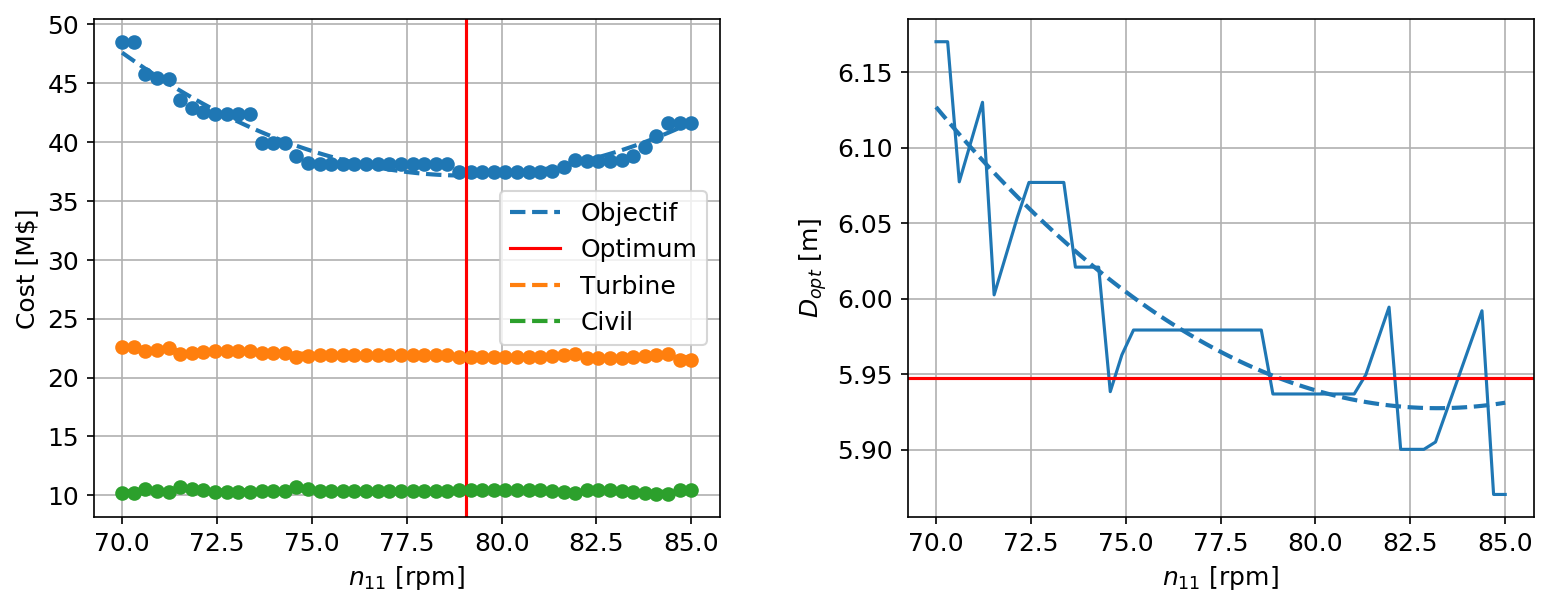

In [21]:
plt.rcParams['font.size']  = 12
plt.rcParams['figure.dpi'] = 150
   
fig,ax = plt.subplots(1,2, figsize=(12,4), sharex=True)
plt.subplots_adjust(hspace=0.02,wspace = 0.3,left = 0.17,right = 0.97,bottom = 0.1,top = 0.93)
ax[0].plot(results_optim.loc[:,'n11'],results_optim.loc[:,'$ optim']/1.0e6,
           linestyle='none',marker='o',color='C0')
xx, yy = p_cost_obj.linspace()
ax[0].plot(xx, yy/1.0e6, lw=2,color='C0',ls='--',label='Objectif')
ax[0].axvline(n11_min_costs,color='red',label='Optimum')
ax[0].plot(results_optim.loc[:,'n11'],results_optim.loc[:,'$ turbine']/1.0e6,
           linestyle='none',marker='o',color='C1')
xx, yy = p_cost_turb.linspace()
ax[0].plot(xx, yy/1.0e6, lw=2,color='C1',ls='--',label='Turbine')
ax[0].plot(results_optim.loc[:,'n11'],results_optim.loc[:,'$ civil']/1.0e6,
           linestyle='none',marker='o',color='C2')
xx, yy = p_cost_civil.linspace()
ax[0].plot(xx, yy/1.0e6, lw=2,color='C2',ls='--',label='Civil')

ax[0].set_xlabel(r'$n_{11}$ [rpm]')
ax[0].set_ylabel(r'Cost [M$]')
ax[0].grid();
ax[0].legend();

ax[1].plot(results_optim.loc[:,'n11'],results_optim.loc[:,'D_opt'])
xx, yy = p_Diam.linspace()
ax[1].plot(xx, yy, lw=2,color='C0',ls='--',label='Objectif')
ax[1].axhline(p_Diam(n11_min_costs), color='red')

ax[1].set_xlabel(r'$n_{11}$ [rpm]')
ax[1].set_ylabel(r'$D_{opt}$ [m]' );
ax[1].grid();

## Résultats de l'optimisation

In [30]:
n11_opt = n11_min_costs;
D_opt = p_Diam(n11_min_costs);
print('Optimal n11={0:.2f} rpm'.format(n11_opt))
print('Optimal D={0:.3f} m'.format(D_opt))
gain,cost_turbine,n_rpm_sync,d_eta_maj_pm,ponderation,eta_p_weighted = rendement_pondere(colline_modele,n11_opt,D_opt);
geometry_penalty(colline_modele,D_opt,display=True);

Optimal n11=79.05 rpm
Optimal D=5.947 m
Nombre de poles: 35
eta_M_max = 93.409 %
Re_p = 1.456e+08
Pertes relatives transposables à Re_M=7e+06 avec V_ref=0.7 pour une turbine Francis
delta_M=4.613 %
Majoration du rendement calculee
d_eta_maj_pm=1.775 %
Vitesse synchrone: 102.86 rpm
Rendement pondéré: 93.788 %
Depassement entraxe: 22.29 m 
Depassement hauteur aspirateur: 4.36 m
Depassement decentrement: 2.84 m


In [28]:
print('Optimal rendement ponderee {0:.2f} %'.format(eta_p_weighted*100))
ponderation

Optimal rendement ponderee 93.79 %


,% P_m,Poids,Puissance [W],Eta [-]
0,100,10,1.524390e+08,0.921242
1,90,20,1.371951e+08,0.951594
2,82,40,1.250000e+08,0.949682
3,70,20,1.067073e+08,0.927304
4,60,10,9.146341e+07,0.901071


In [29]:
colline_modele.proto_geom

,ID,Description,Valeur,Unite
0,A,Diamètre roue,5947.239540,mm
1,B,Hauteur du distributeur,1700.910508,mm
2,C,Distance bas aube - axe du distrituteur,2438.368211,mm
3,D,Distance axe du distrituteur - fond de l'aspi...,16194.333267,mm
4,E,Distance axe roue - sortie aspirateur,26566.319025,mm
5,F,Largeur aspirateur,19167.953037,mm
6,G,Distance axe roue - bâche rive droite *,10710.978411,mm
7,H,Distance axe roue - bâche rive gauche,7874.145151,mm
8,I,Distance axe roue - entrée bâche,8094.193014,mm
9,J,Hauteur sortie aspirateur pour calcul Ec,4359.326583,mm


In [31]:
n11_sync_check_min,_,gamma_pc_Hmin,Q_pc_Hmin,eta_P_pc_Hmin,P_mp_pc_Hmin = colline_modele.prise_charge(n_rpm_sync*D_opt/np.sqrt(Hmin),D_opt,rho,g,Hmin,nu,npts_intp=100,flag_plot=False,d_eta_maj_pm=d_eta_maj_pm)
n11_sync_check,_,gamma_pc_nom,Q_pc_nom,eta_P_pc_nom,P_mp_pc_nom = colline_modele.prise_charge(n_rpm_sync*D_opt/np.sqrt(H),D_opt,rho,g,H,nu,npts_intp=100,flag_plot=False,d_eta_maj_pm=d_eta_maj_pm)
n11_sync_check_max,_,gamma_pc_Hmax,Q_pc_Hmax,eta_P_pc_Hmax,P_mp_pc_Hmax = colline_modele.prise_charge(n_rpm_sync*D_opt/np.sqrt(Hmax),D_opt,rho,g,Hmax,nu,npts_intp=100,flag_plot=False,d_eta_maj_pm=d_eta_maj_pm)

Nombre de poles: 35
Majoration du rendement specifiee
d_eta_maj_pm=1.775 %
Nombre de poles: 35
Majoration du rendement specifiee
d_eta_maj_pm=1.775 %
Nombre de poles: 35
Majoration du rendement specifiee
d_eta_maj_pm=1.775 %


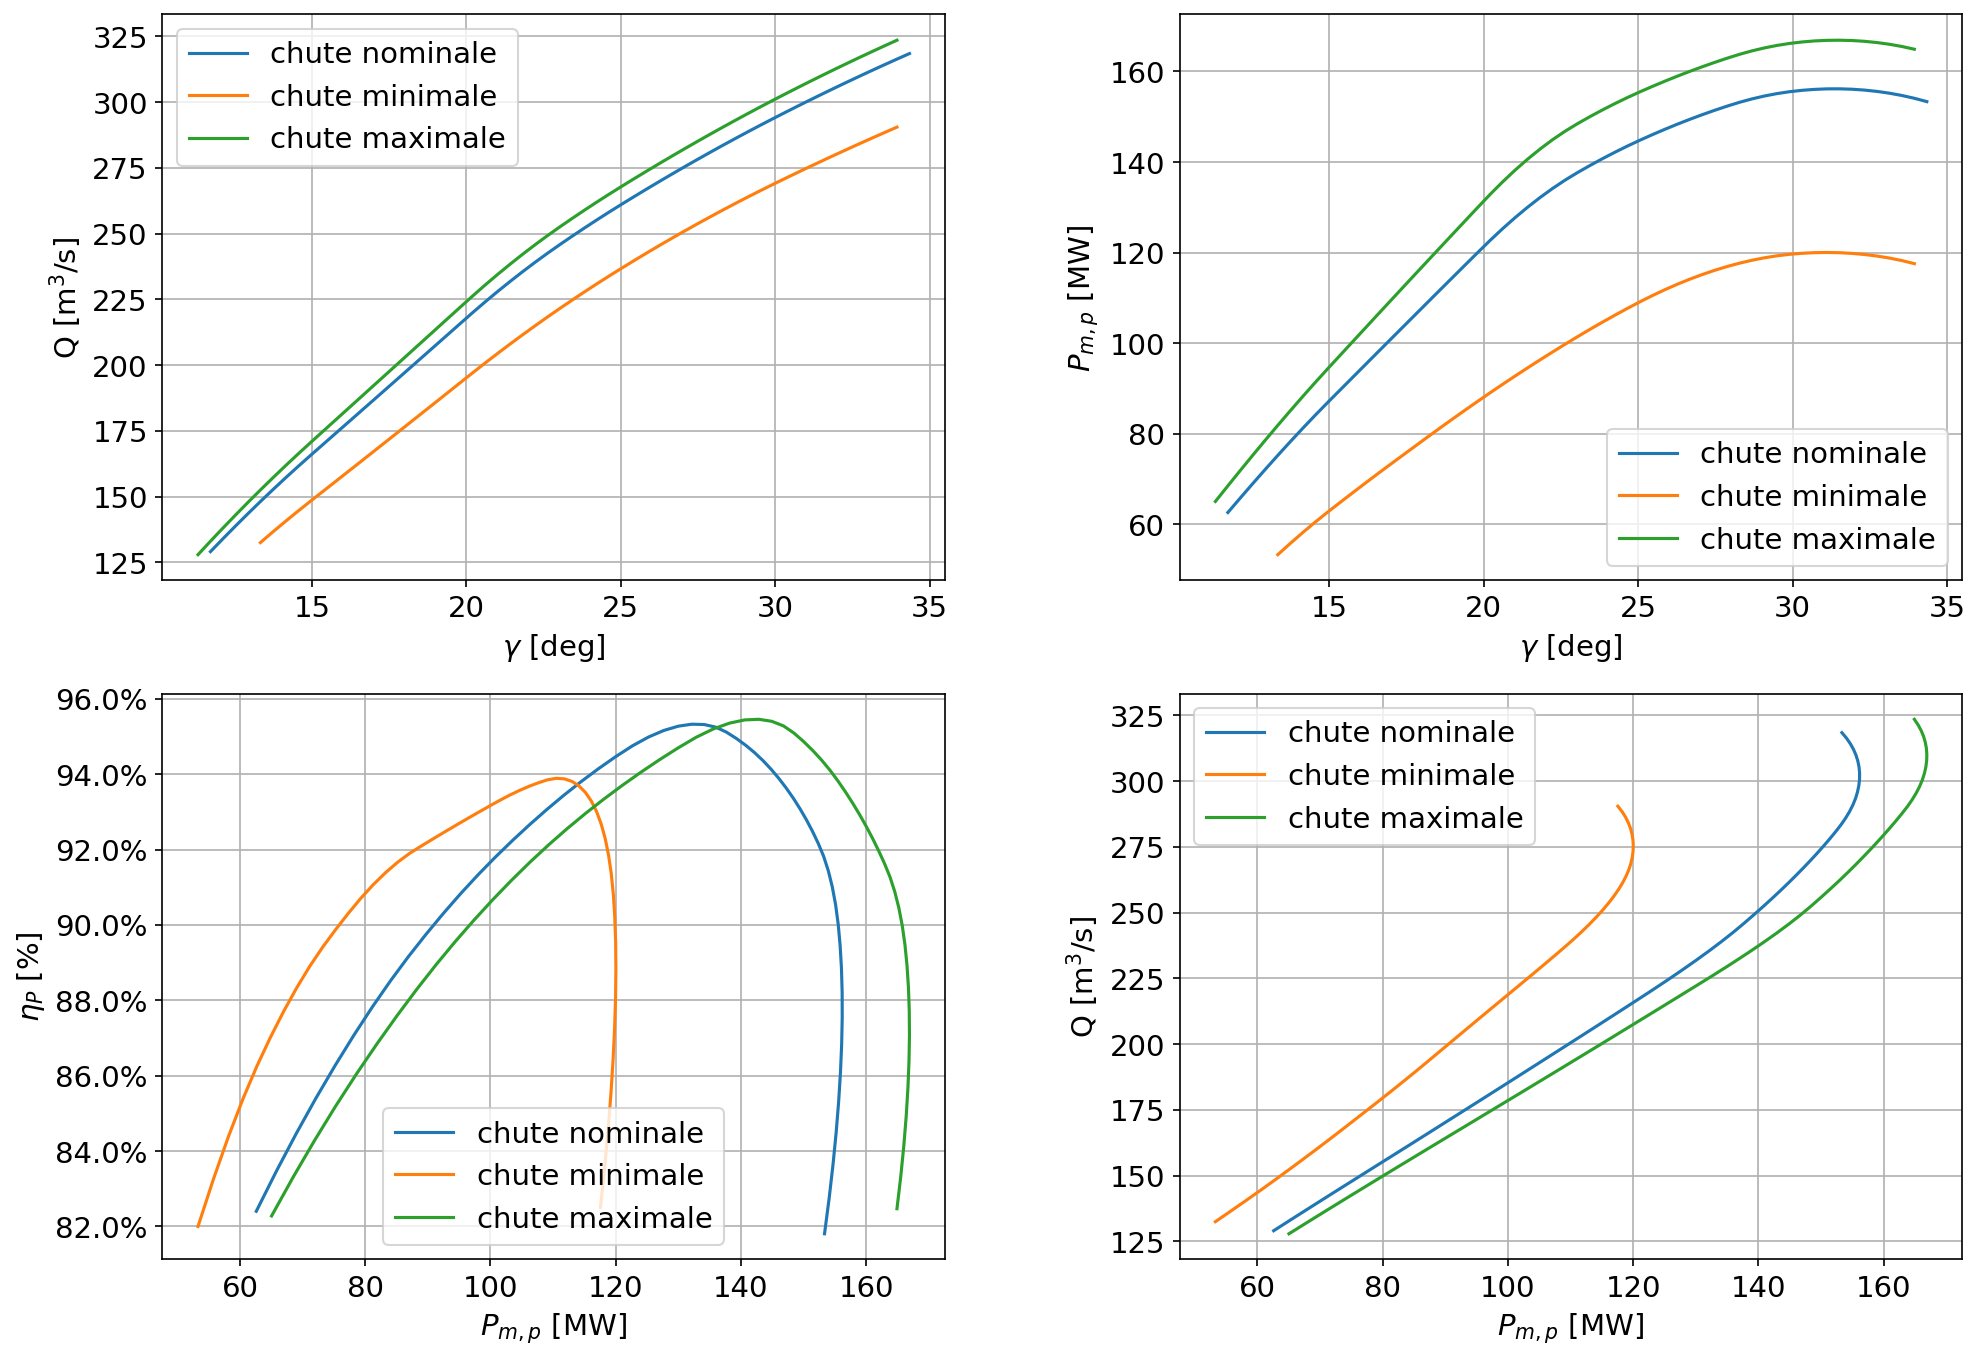

In [40]:
# quelques parametres pour l'affichage des figures
plt.rcParams['font.size']  = 14
plt.rcParams['figure.dpi'] = 150
    
fig,ax = plt.subplots(2,2, figsize=(15,10))
plt.subplots_adjust(hspace=0.2,wspace = 0.3,left = 0.17,right = 0.97,bottom = 0.1,top = 0.93)

ax[0,0].plot(gamma_pc_nom,Q_pc_nom,label='chute nominale')
ax[0,0].plot(gamma_pc_Hmin,Q_pc_Hmin,label='chute minimale')
ax[0,0].plot(gamma_pc_Hmax,Q_pc_Hmax,label='chute maximale')
ax[0,0].set_xlabel(r'$\gamma$ [deg]')
ax[0,0].set_ylabel(r'Q [m$^3$/s]')
ax[0,0].grid()
ax[0,0].legend()

ax[0,1].plot(gamma_pc_nom,P_mp_pc_nom/1.0e6,label='chute nominale')
ax[0,1].plot(gamma_pc_Hmin,P_mp_pc_Hmin/1.0e6,label='chute minimale')
ax[0,1].plot(gamma_pc_Hmax,P_mp_pc_Hmax/1.0e6,label='chute maximale')
ax[0,1].set_xlabel(r'$\gamma$ [deg]')
ax[0,1].set_ylabel(r'$P_{m,p}$ [MW]')
ax[0,1].grid()
ax[0,1].legend()

ax[1,0].plot(P_mp_pc_nom/1.0e6,eta_P_pc_nom,label='chute nominale')
ax[1,0].plot(P_mp_pc_Hmin/1.0e6,eta_P_pc_Hmin,label='chute minimale')
ax[1,0].plot(P_mp_pc_Hmax/1.0e6,eta_P_pc_Hmax,label='chute maximale')
ax[1,0].set_ylabel(r'$\eta_{P}$ [%]')
ax[1,0].set_xlabel(r'$P_{m,p}$ [MW]')
ax[1,0].yaxis.set_major_formatter(tck.PercentFormatter(xmax=1.0))
ax[1,0].grid()
ax[1,0].legend()

ax[1,1].plot(P_mp_pc_nom/1.0e6,Q_pc_nom,label='chute nominale')
ax[1,1].plot(P_mp_pc_Hmin/1.0e6,Q_pc_Hmin,label='chute minimale')
ax[1,1].plot(P_mp_pc_Hmax/1.0e6,Q_pc_Hmax,label='chute maximale')
ax[1,1].set_ylabel(r'Q [m$^3$/s]')
ax[1,1].set_xlabel(r'$P_{m,p}$ [MW]')
ax[1,1].grid()
ax[1,1].legend()